# Supervised Learning - Assignment nº 2
## Loan Approval Prediction


### Description
The goal is to develop a machine learning model that predicts if a loan application is approved or not. 

The target variable is loan_status, a binary label where 1 indicates the loan is approved and 0 means it is not.

The dataset provided for training and testing was generated from a deep learning model trained on the Loan Approval Prediction dataset.

#### Files

- **train.csv**: Contains the training data, including the target variable loan_status.

- **test.csv**: Test data where the task is to predict the probability of loan approval (loan_status).

### Import libraries
Before running the notebook, make sure all the necessary libraries are installed.

This project includes a `requirements.txt` file that lists all dependencies.

To install them, run the following command in your terminal: ` pip install -r requirements.txt `

In [64]:
import warnings
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statistics
from scipy import stats

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score, roc_curve, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, learning_curve, GridSearchCV

import sklearn.tree as tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.feature_selection import SelectKBest, RFE, f_classif
from sklearn.pipeline import Pipeline

from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier

from tensorflow import keras
from tensorflow.keras import layers

from xgboost import XGBClassifier

warnings.filterwarnings('ignore')

### Loading the Training Data

In [65]:
data = pd.read_csv('train.csv')

### Exploratory Data Analysis 

#### General infomation

In [66]:
print("Dataset info:")
print(data.info())
print("\n")

print("Status:")
print(data['loan_status'].unique())
print("\n")

print("First 5 rows of the dataset:")
print(data.head())
print("\n")

print("Summary statistics:")
print(data.describe())

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58645 entries, 0 to 58644
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          58645 non-null  int64  
 1   person_age                  58645 non-null  int64  
 2   person_income               58645 non-null  int64  
 3   person_home_ownership       58645 non-null  object 
 4   person_emp_length           58645 non-null  float64
 5   loan_intent                 58645 non-null  object 
 6   loan_grade                  58645 non-null  object 
 7   loan_amnt                   58645 non-null  int64  
 8   loan_int_rate               58645 non-null  float64
 9   loan_percent_income         58645 non-null  float64
 10  cb_person_default_on_file   58645 non-null  object 
 11  cb_person_cred_hist_length  58645 non-null  int64  
 12  loan_status                 58645 non-null  int64  
dtypes: float64(3), in

#### Distribution of target variable


--- Distribution of target variable ---
loan_status
0    85.761787
1    14.238213
Name: proportion, dtype: float64


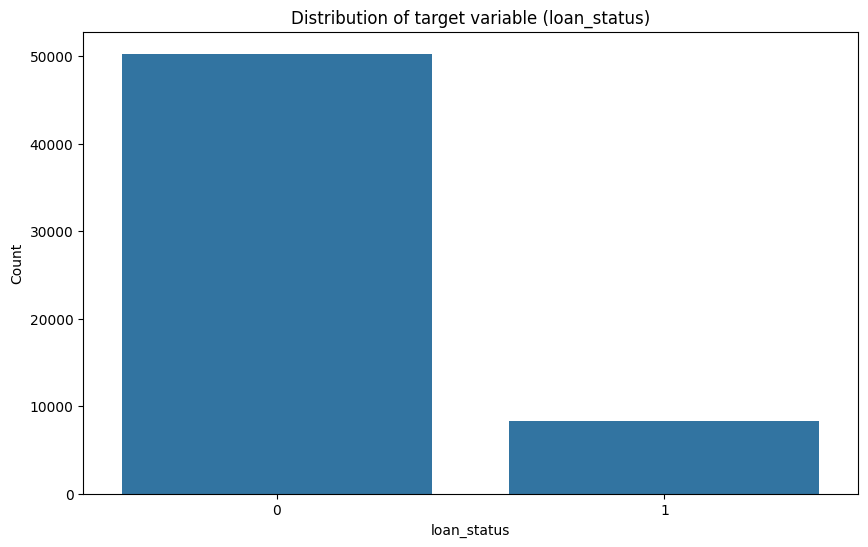

In [67]:
print("\n--- Distribution of target variable ---")
loan_status_counts = data['loan_status'].value_counts(normalize=True) * 100
print(loan_status_counts)

plt.figure(figsize=(10, 6))
sns.countplot(x='loan_status', data=data)
plt.title('Distribution of target variable (loan_status)')
plt.ylabel('Count')
plt.show()

### Data preprocessing 
#### Missing values

In [68]:
print("\n--- Missing values ---")
missing_values = data.isnull().sum()
print(missing_values)

print("\nRows containing missing values:")
print(data[data.isnull().any(axis=1)])


--- Missing values ---
id                            0
person_age                    0
person_income                 0
person_home_ownership         0
person_emp_length             0
loan_intent                   0
loan_grade                    0
loan_amnt                     0
loan_int_rate                 0
loan_percent_income           0
cb_person_default_on_file     0
cb_person_cred_hist_length    0
loan_status                   0
dtype: int64

Rows containing missing values:
Empty DataFrame
Columns: [id, person_age, person_income, person_home_ownership, person_emp_length, loan_intent, loan_grade, loan_amnt, loan_int_rate, loan_percent_income, cb_person_default_on_file, cb_person_cred_hist_length, loan_status]
Index: []


#### 

#### Correlation of atributes

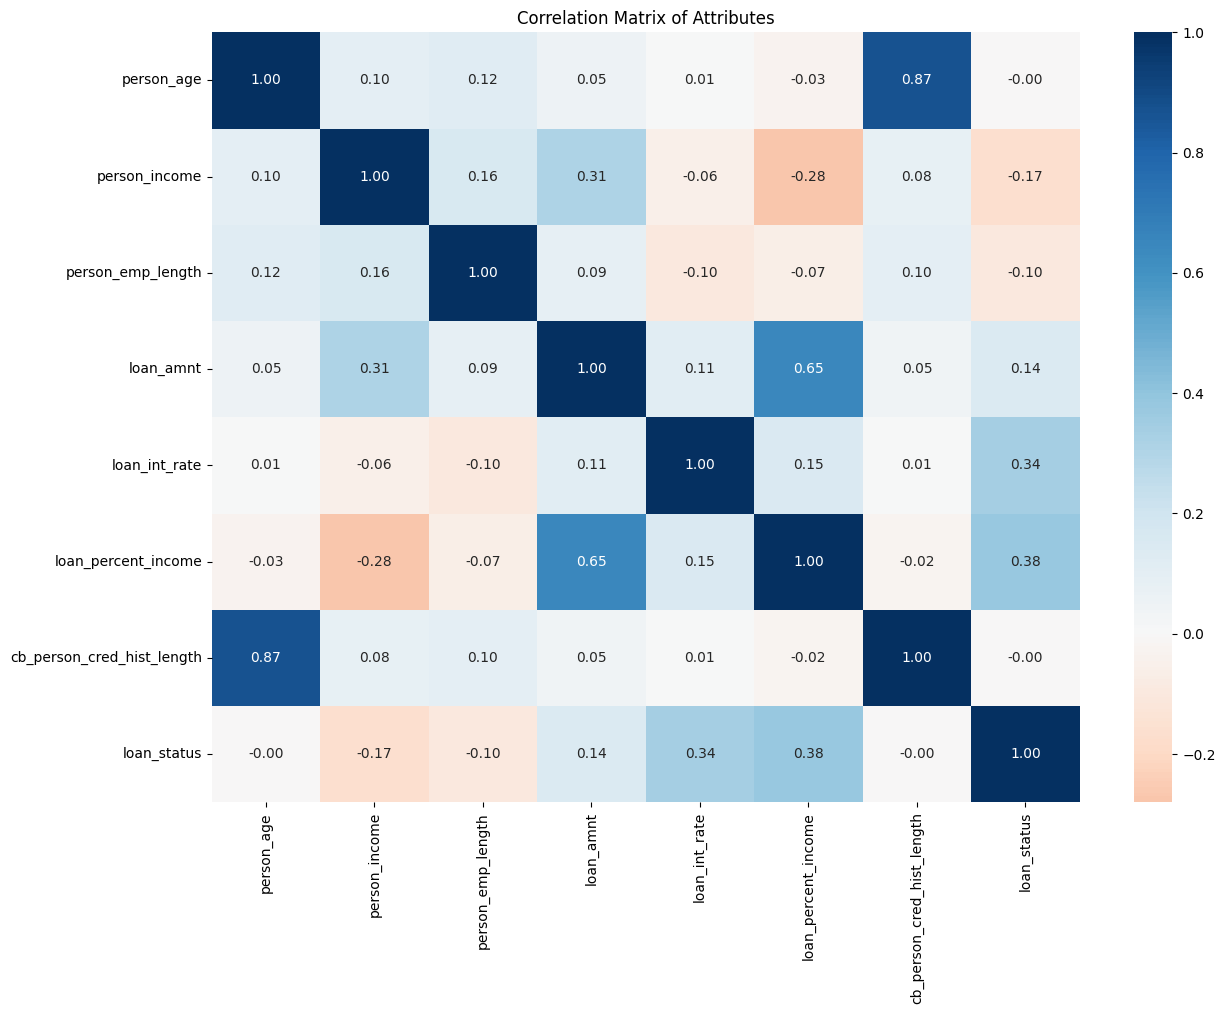

In [69]:
data_encoded = pd.get_dummies(data.drop(columns=["id", "person_home_ownership", "loan_intent", "loan_grade", "cb_person_default_on_file"]))

correlation_matrix = data_encoded.corr()

plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='RdBu', center=0)
plt.title("Correlation Matrix of Attributes")
plt.show()

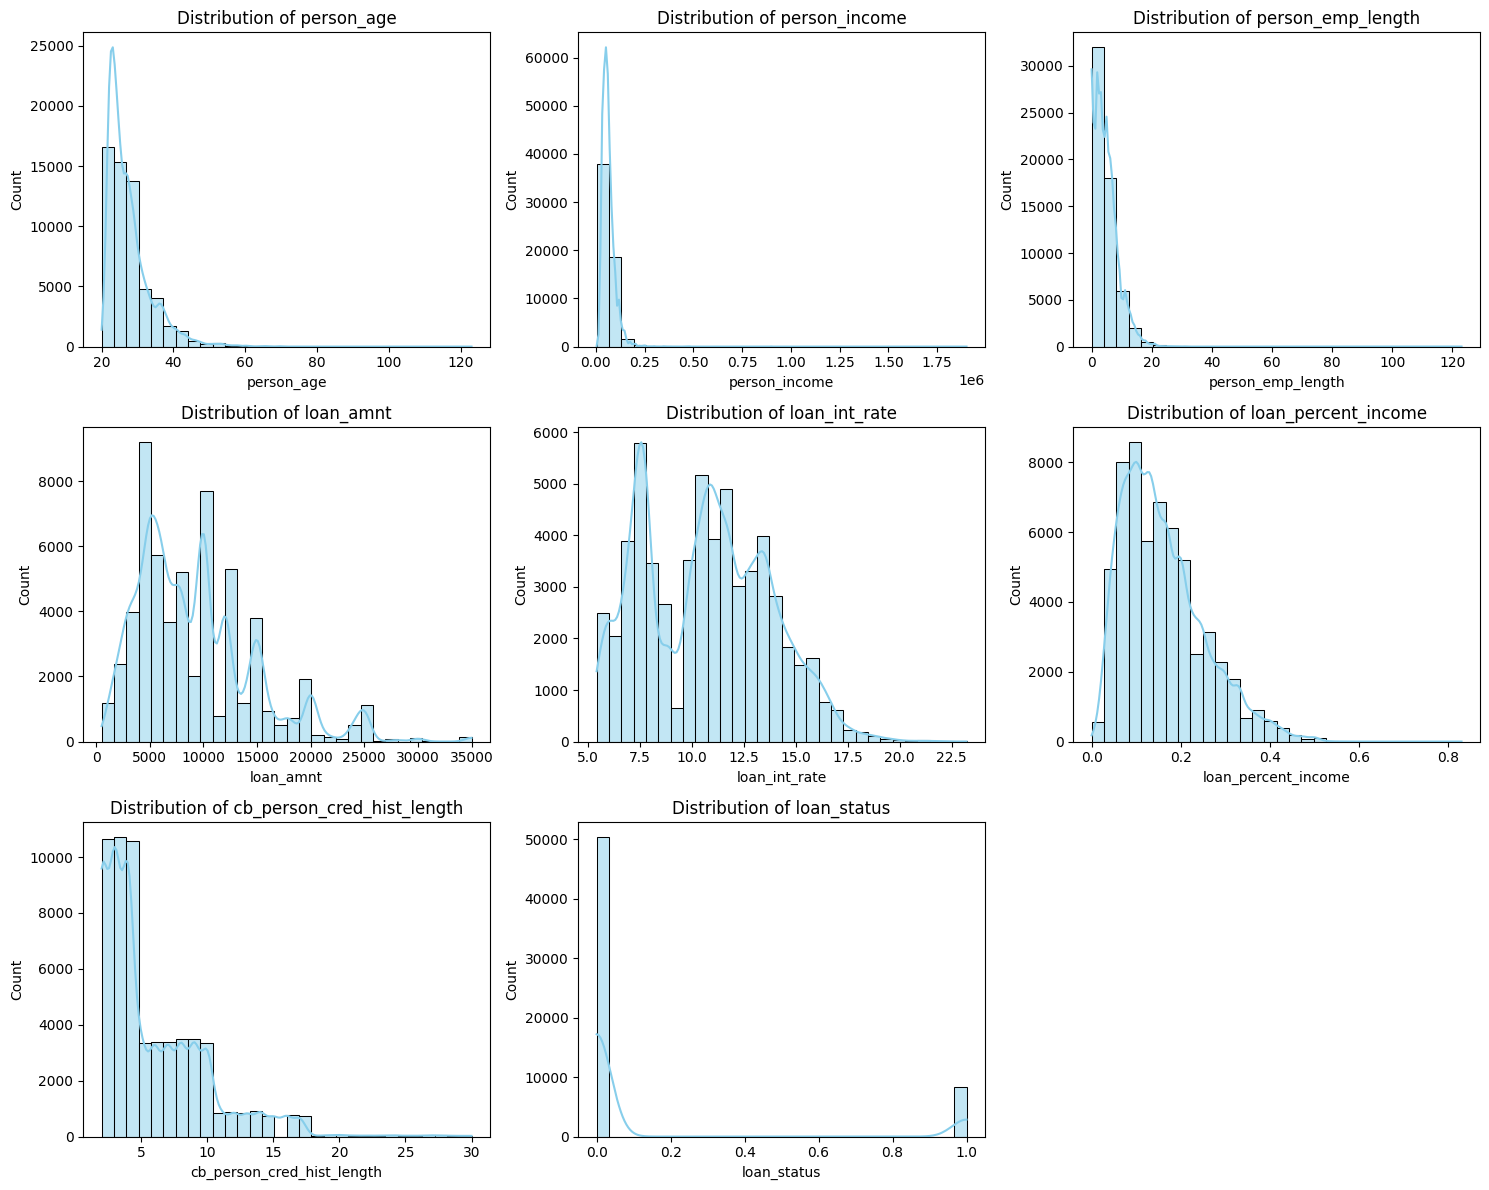

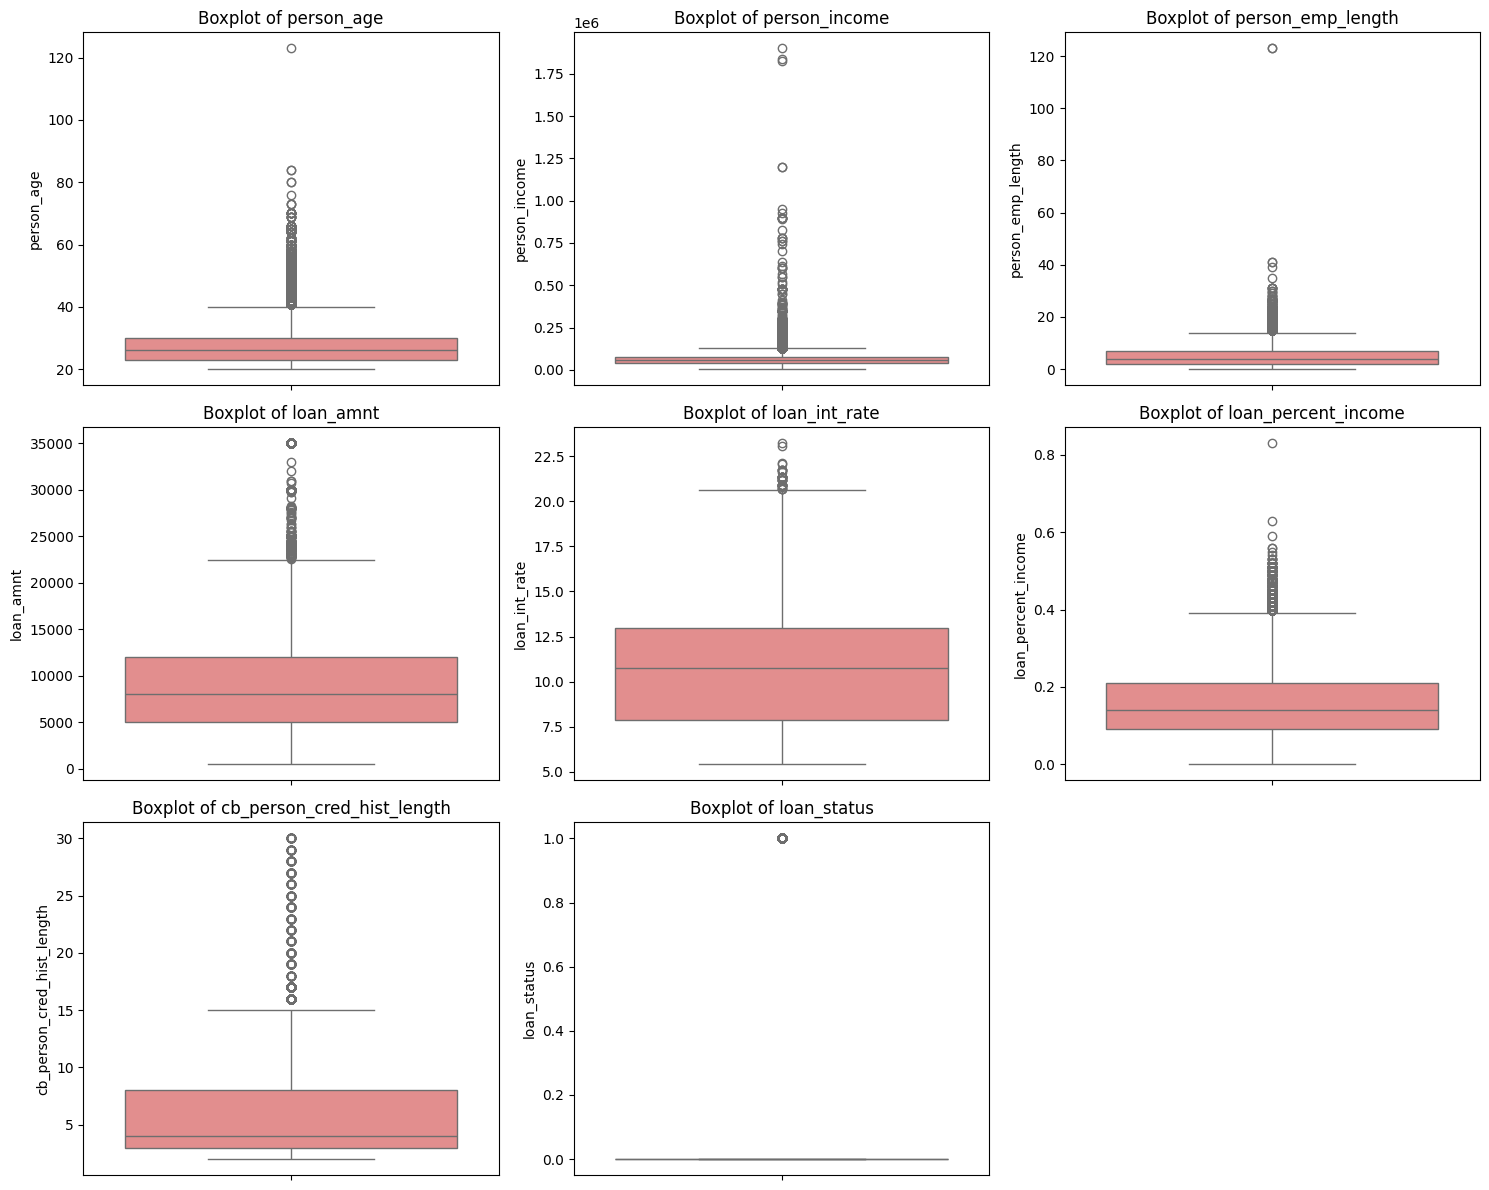

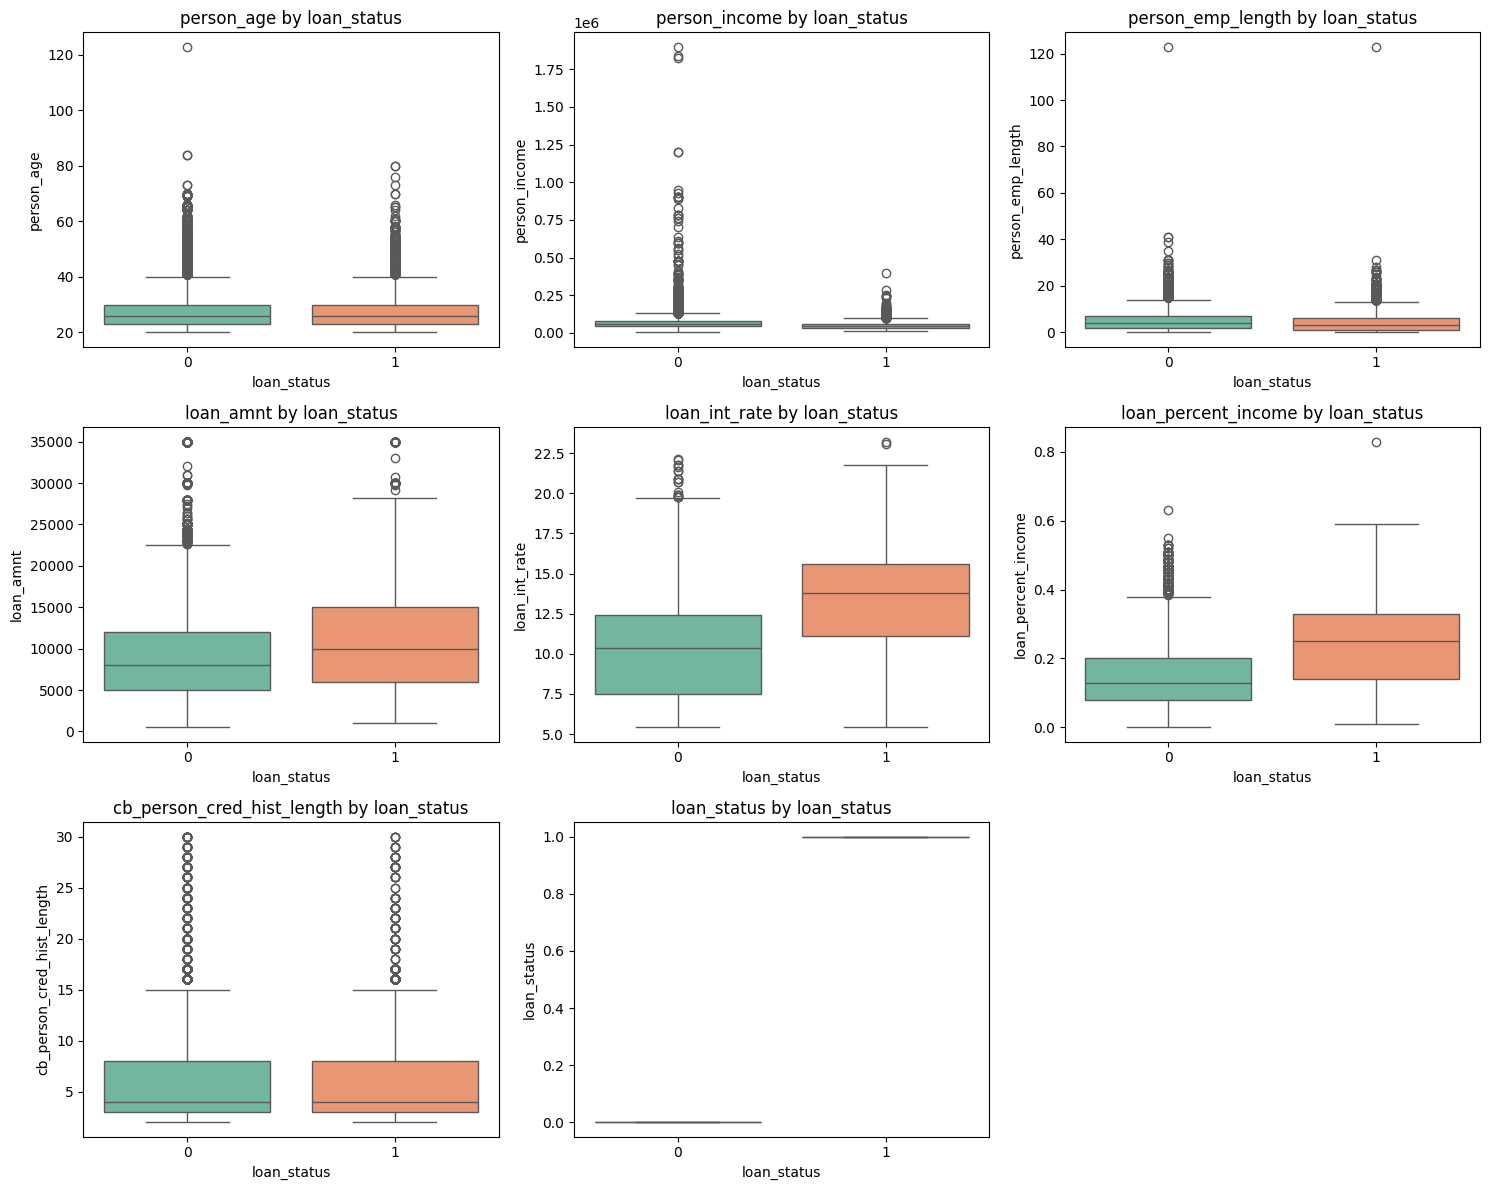

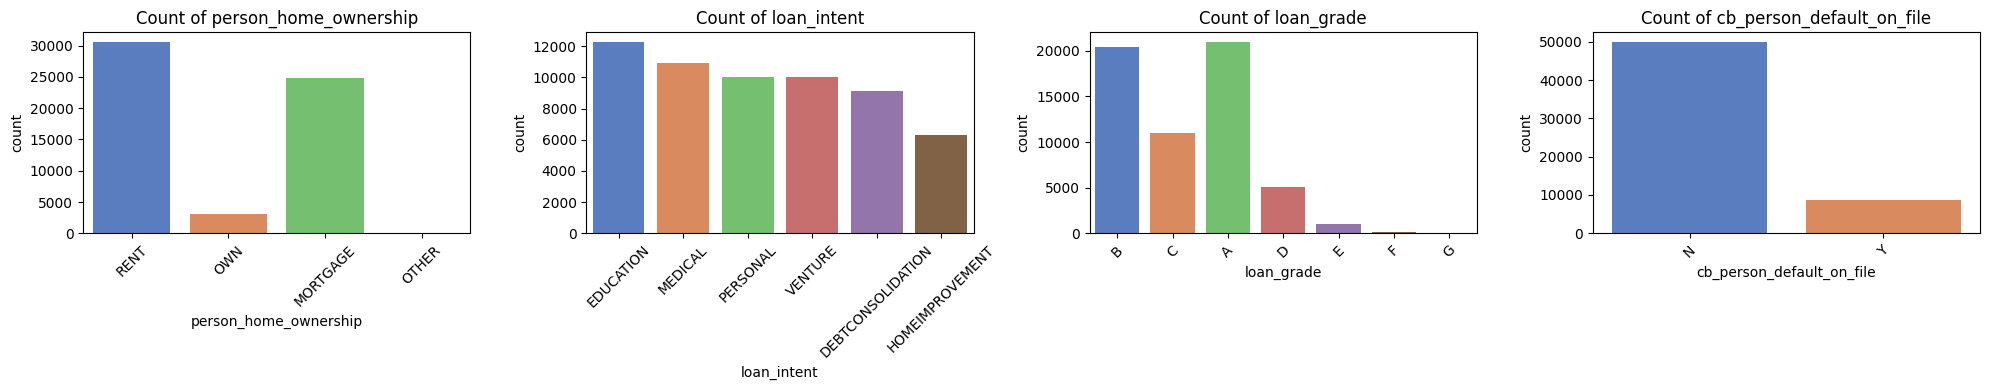

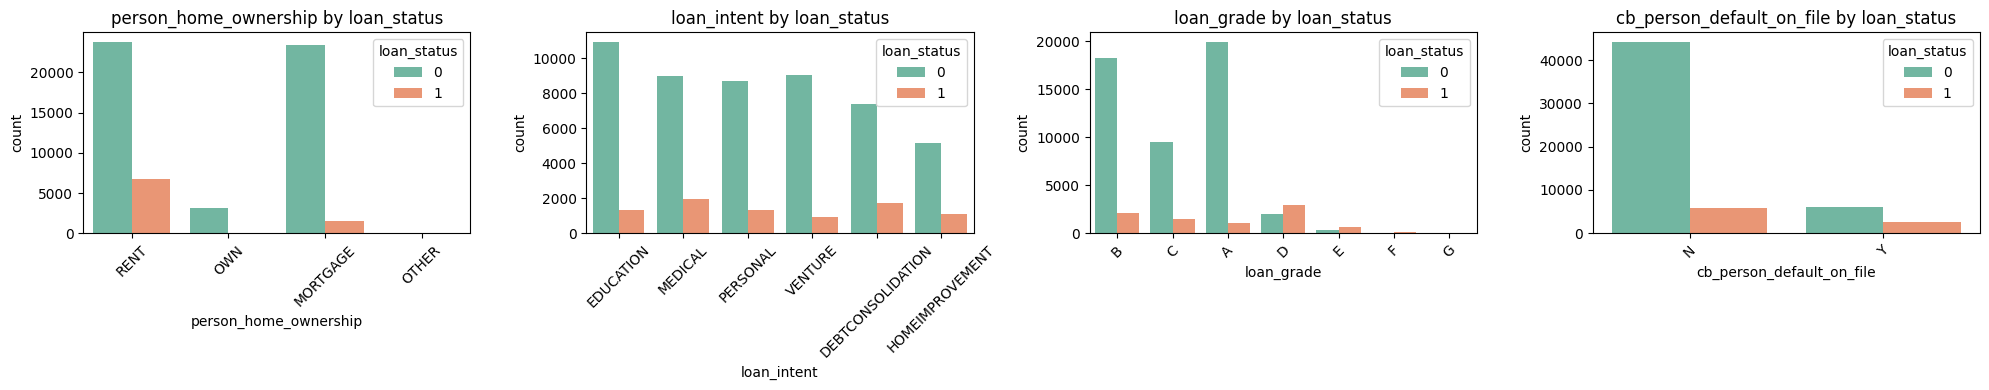

In [70]:
def plot_numeric_distributions(data, numeric_cols, cols_per_row=3, bins=30):
    rows = (len(numeric_cols) + cols_per_row - 1) // cols_per_row
    fig, axes = plt.subplots(rows, cols_per_row, figsize=(5 * cols_per_row, 4 * rows))
    axes = axes.flatten()

    for i, col in enumerate(numeric_cols):
        sns.histplot(data[col], ax=axes[i], kde=True, bins=bins, color='skyblue')
        axes[i].set_title(f'Distribution of {col}')

    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
    
    plt.tight_layout()
    plt.show()

def plot_numeric_boxplots(data, numeric_cols, cols_per_row=3):
    rows = (len(numeric_cols) + cols_per_row - 1) // cols_per_row
    fig, axes = plt.subplots(rows, cols_per_row, figsize=(5 * cols_per_row, 4 * rows))
    axes = axes.flatten()

    for i, col in enumerate(numeric_cols):
        sns.boxplot(y=data[col], ax=axes[i], color='lightcoral')
        axes[i].set_title(f'Boxplot of {col}')
    
    # Remove unused axes
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
    
    plt.tight_layout()
    plt.show()


def plot_numeric_boxplots_by_target(data, numeric_cols, target_col, cols_per_row=3):
    rows = (len(numeric_cols) + cols_per_row - 1) // cols_per_row
    fig, axes = plt.subplots(rows, cols_per_row, figsize=(5 * cols_per_row, 4 * rows))
    axes = axes.flatten()

    for i, col in enumerate(numeric_cols):
        sns.boxplot(x=target_col, y=col, data=data, ax=axes[i], hue=target_col, palette='Set2', legend=False)
        axes[i].set_title(f'{col} by {target_col}')
    
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
    
    plt.tight_layout()
    plt.show()


def plot_categorical_columns(data, categorical_cols, cols_per_row=4):
    rows = (len(categorical_cols) + cols_per_row - 1) // cols_per_row
    fig, axes = plt.subplots(rows, cols_per_row, figsize=(5 * cols_per_row, 4 * rows))
    axes = axes.flatten()

    for i, col in enumerate(categorical_cols):
        sns.countplot(x=col, hue=col, data=data, ax=axes[i], palette='muted', legend=False)
        axes[i].set_title(f'Count of {col}')
        axes[i].tick_params(axis='x', rotation=45)
    
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
    
    plt.tight_layout()
    plt.show()

def plot_categorical_columns_by_target(data, categorical_cols, target_col='loan_status', cols_per_row=4):
    rows = (len(categorical_cols) + cols_per_row - 1) // cols_per_row
    fig, axes = plt.subplots(rows, cols_per_row, figsize=(5 * cols_per_row, 4 * rows))
    axes = axes.flatten()

    for i, col in enumerate(categorical_cols):
        sns.countplot(x=col, hue=target_col, data=data, ax=axes[i], palette='Set2')
        axes[i].set_title(f'{col} by {target_col}')
        axes[i].tick_params(axis='x', rotation=45)
    
    # Remove eixos não utilizados
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
    
    plt.tight_layout()
    plt.show()


numeric_cols = data.select_dtypes(include=['int64', 'float64']).columns.tolist()
numeric_cols.remove('id')  # Se não quiseres o 'id'
categorical_cols = data.select_dtypes(include=['object']).columns.tolist()

# Plots
plot_numeric_distributions(data, numeric_cols)
plot_numeric_boxplots(data, numeric_cols)
plot_numeric_boxplots_by_target(data, numeric_cols, target_col='loan_status')
plot_categorical_columns(data, categorical_cols)
plot_categorical_columns_by_target(data, categorical_cols, target_col='loan_status')

### Preparation of data

In [71]:
# Convert categorical variables to numerical
data = pd.get_dummies(data, columns=["person_home_ownership", "loan_intent", "loan_grade", "cb_person_default_on_file"])

# Convert boolean values to integers
data = data.astype({col: int for col in data.select_dtypes(include=['bool']).columns})

all_inputs = data.drop(columns=["loan_status", "id"]).values
all_labels = data["loan_status"].values

# Normalize the data
scaler = StandardScaler()
all_inputs_scaled = scaler.fit_transform(all_inputs)

# Check the dtype of all_inputs
print(all_inputs.dtype)


float64


# Supervised Learning Algorithms

### Model Evaluation Functions

In [72]:
def plot_model_metrics(model, X, y, n_splits=10, random_state=42):
    """
    Calculates classification metrics using k-fold cross validation and displays them in a table.
    
    Args:
        model: The classifier model
        X: Input features
        y: Target labels
        n_splits: Number of folds for cross-validation
        random_state: Random state for reproducibility
    """
    accuracy_scores = []
    precision_scores = []
    recall_scores = []
    f1_scores = []
    confusion_matrices = []
    
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    
    for train_idx, test_idx in cv.split(X, y):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        accuracy_scores.append(accuracy_score(y_test, y_pred))
        precision_scores.append(precision_score(y_test, y_pred))
        recall_scores.append(recall_score(y_test, y_pred))
        f1_scores.append(f1_score(y_test, y_pred))
        confusion_matrices.append(confusion_matrix(y_test, y_pred))
    
    # Calculate means and standard deviations
    metrics_data = {
        'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score'],
        'Mean': [
            np.mean(accuracy_scores),
            np.mean(precision_scores),
            np.mean(recall_scores),
            np.mean(f1_scores)
        ],
        'Std': [
            np.std(accuracy_scores),
            np.std(precision_scores),
            np.std(recall_scores),
            np.std(f1_scores)
        ]
    }
    
    df_metrics = pd.DataFrame(metrics_data)
    df_metrics['Score'] = df_metrics.apply(lambda x: f"{x['Mean']:.4f} (±{x['Std']:.4f})", axis=1)
    df_metrics = df_metrics[['Metric', 'Score']]
    
    display(df_metrics.style
       .hide(axis='index') 
       .set_properties(**{'text-align': 'center'})
       .set_table_styles([
           {'selector': 'th', 'props': [('text-align', 'center'), ('font-weight', 'bold')]},
           {'selector': 'td', 'props': [('text-align', 'center')]}
       ]))
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.25, stratify=y, random_state=random_state
    )
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='Blues')
    plt.title(f"Confusion Matrix")
    plt.show()
    
    return {
        'accuracy': np.mean(accuracy_scores),
        'precision': np.mean(precision_scores),
        'recall': np.mean(recall_scores),
        'f1': np.mean(f1_scores),
        'confusion_matrix': cm
    }

def compare_metrics(metrics_dict):
    """
    Creates a bar plot comparing accuracy, precision, recall and F1-score across models.
    
    Args:
        metrics_dict: Dictionary with model names and their metrics from plot_model_metrics()
        Example: {'Decision Tree': metrics_dt, 'Random Forest': metrics_rf, ...}
    """
    models = list(metrics_dict.keys())
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1']
    
    plt.figure(figsize=(12, 6))
    
    x = np.arange(len(models))
    width = 0.2
    multiplier = 0
    
    for metric in metrics:
        metric_lower = metric.lower()
        values = [metrics[metric_lower] for metrics in metrics_dict.values()]
        offset = width * multiplier
        plt.bar(x + offset, values, width, label=metric)
        multiplier += 1
    
    plt.ylabel('Score')
    plt.title('Model Performance Comparison')
    plt.xticks(x + width * 1.5, models, rotation=45)
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# ----------------------------------------------------------------------
## Decision Tree

### 100 Repetitions default run

Accuracy: 0.9133


Text(0, 0.5, 'Frequency')

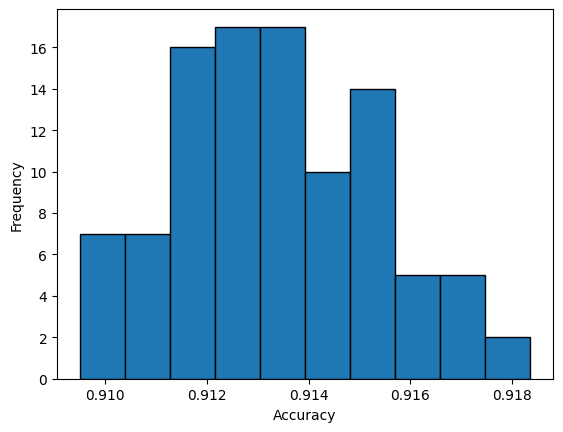

In [50]:
model_accuracies = []

for repetition in range(100):
    (training_inputs,
     testing_inputs,
     training_classes,
     testing_classes) = train_test_split(all_inputs, all_labels, test_size=0.25)
    
    decision_tree_classifier = DecisionTreeClassifier(random_state=1)
    decision_tree_classifier.fit(training_inputs, training_classes)
    predicted_classes = decision_tree_classifier.predict(testing_inputs)
    model_accuracies.append(accuracy_score(testing_classes, predicted_classes))

average_accuracy = statistics.mean(model_accuracies)
print(f"Accuracy: {average_accuracy:.4f}")

plt.hist(model_accuracies, edgecolor='black')
plt.xlabel('Accuracy')
plt.ylabel('Frequency')

### Decision tree with k-fold

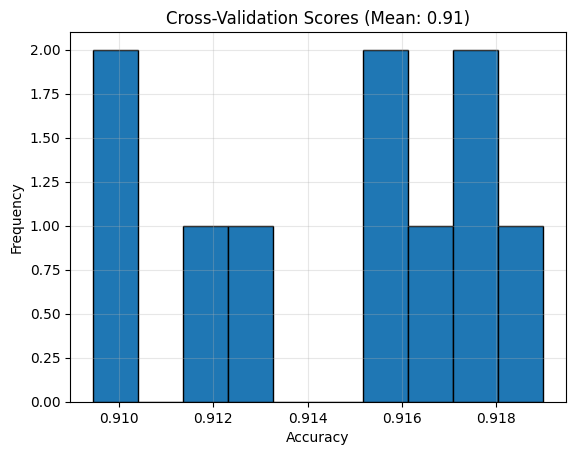

[0.91167945 0.91679454 0.91611253 0.91713555 0.91560102 0.91899727
 0.91302865 0.91746248 0.90995907 0.90944748]
Average accuracy across 10 folds: 0.9146


In [51]:
decision_tree_classifier = DecisionTreeClassifier()

stratified_kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
cv_scores = cross_val_score(decision_tree_classifier, all_inputs, all_labels, cv=stratified_kfold)

plt.hist(cv_scores, bins=10, edgecolor='black')
plt.title(f'Cross-Validation Scores (Mean: {np.mean(cv_scores):.2f})')
plt.xlabel('Accuracy')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
plt.show()

print(cv_scores)
print(f"Average accuracy across 10 folds: {np.mean(cv_scores):.4f}")

Here we observe a small improvement compared to the default Decision Tree run. This improvement is due to the use of StratifiedKFold, which ensures that each fold used during cross-validation maintains the same class distribution as the original dataset. This leads to a more balanced and representative evaluation, especially when the classes are imbalanced, and helps the model generalize better across all data splits.

### Find best performing parameters for Decision Tree with k-fold (just max depth and max features)

Best score: 0.9456218939322572
Best parameters: {'max_depth': 10, 'max_features': 10}


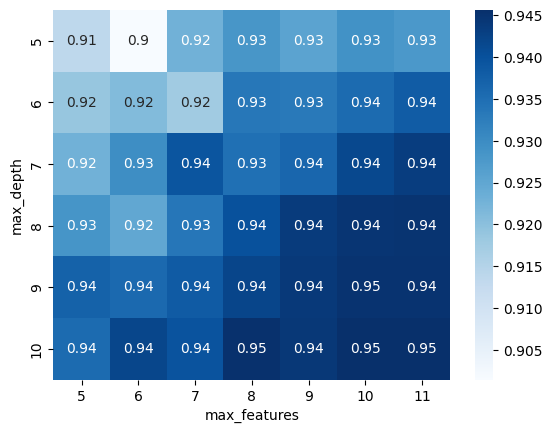

In [52]:

decision_tree_classifier = DecisionTreeClassifier()

parameter_grid = {
    'max_depth': [5, 6, 7, 8, 9, 10],
    'max_features': [5, 6, 7, 8, 9, 10, 11],
}

cross_validation = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
grid_search = GridSearchCV(
    estimator=decision_tree_classifier,
    param_grid=parameter_grid,
    cv=cross_validation,
    scoring='accuracy'
)
grid_search.fit(all_inputs, all_labels)

grid_visualization = grid_search.cv_results_['mean_test_score']
grid_visualization.shape = (len(parameter_grid['max_depth']), len(parameter_grid['max_features']))

sns.heatmap(grid_visualization, cmap='Blues', annot=True)
plt.xticks(np.arange(len(parameter_grid['max_features'])) + 0.5, parameter_grid['max_features'])
plt.yticks(np.arange(len(parameter_grid['max_depth'])) + 0.5, parameter_grid['max_depth'])
plt.xlabel('max_features')
plt.ylabel('max_depth')

print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))



Here we can see that adding more features and allowing greater tree depth clearly improves the performance of the Decision Tree.
This happens because:
    - More features provide more information
    - Increasing the depth of the tree allows it to model more complex relationships in the data

### Find best performing parameters for Decision Tree with k-fold

In [53]:
decision_tree_classifier = DecisionTreeClassifier()

parameter_grid = {'criterion': ['gini', 'entropy'],
                  'splitter': ['best', 'random'],
                    'max_depth': [5, 6, 7, 8, 9, 10],
                        'max_features': [5, 6, 7, 8, 9, 10, 11]}

cross_validation = StratifiedKFold(n_splits=10)

grid_search = GridSearchCV(decision_tree_classifier,
                           param_grid=parameter_grid,
                           cv=cross_validation)

grid_search.fit(all_inputs, all_labels)
print('Best score: {}'.format(grid_search.best_score_))
DecisionTree_bestScore = grid_search.best_score_
print('Best parameters: {}'.format(grid_search.best_params_))

decision_tree_classifier = grid_search.best_estimator_

with open('loan_tree.dot', 'w') as out_file:
    out_file = tree.export_graphviz(decision_tree_classifier, out_file=out_file)

KeyboardInterrupt: 

### Statistics: Learning curve and Plot Roc Curve

In [ ]:
def learning_curve_(grid_search, all_inputs, all_labels):
    best_algorit = grid_search.best_estimator_

    train_sizes, train_scores, val_scores = learning_curve(
        best_algorit, all_inputs, all_labels, cv=5, scoring='accuracy',
        train_sizes=np.linspace(0.1, 1.0, 10), shuffle=True, random_state=42
    )

    train_mean = np.mean(train_scores, axis=1)
    val_mean = np.mean(val_scores, axis=1)

    return train_sizes, train_mean, val_mean


def roc_curve_(grid_search, all_inputs, all_labels):
    training_inputs, testing_inputs, training_classes, testing_classes = train_test_split(
        all_inputs, all_labels, test_size=0.25, stratify=all_labels, random_state=42
    )

    best_algorit = grid_search.best_estimator_
    best_algorit.fit(training_inputs, training_classes)

    y_proba = best_algorit.predict_proba(testing_inputs)[:, 1]

    fpr, tpr, thresholds = roc_curve(testing_classes, y_proba)
    algorit_auc = roc_auc_score(testing_classes, y_proba)

    return fpr, tpr, algorit_auc


def learning_roc_graphs(grid_search, all_inputs, all_labels, name_algorit):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    train_sizes, train_mean, val_mean = learning_curve_(grid_search, all_inputs, all_labels)
    ax1.plot(train_sizes, train_mean, 'o-', label='Training Accuracy')
    ax1.plot(train_sizes, val_mean, 'o-', label='Validation Accuracy')
    ax1.set_xlabel('Training Set Size')
    ax1.set_ylabel('Accuracy')
    ax1.set_title('Learning Curve - ' + name_algorit)
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    fpr, tpr, algorit_auc = roc_curve_(grid_search, all_inputs, all_labels)
    ax2.plot(fpr, tpr, label=f'Random Forest (AUC = {algorit_auc:.4f})')
    ax2.plot([0,1], [0,1], 'k--', label='Random')
    ax2.set_xlabel('False Positive Rate')
    ax2.set_ylabel('True Positive Rate')
    ax2.set_title('ROC Curve - ' + name_algorit)
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.show()


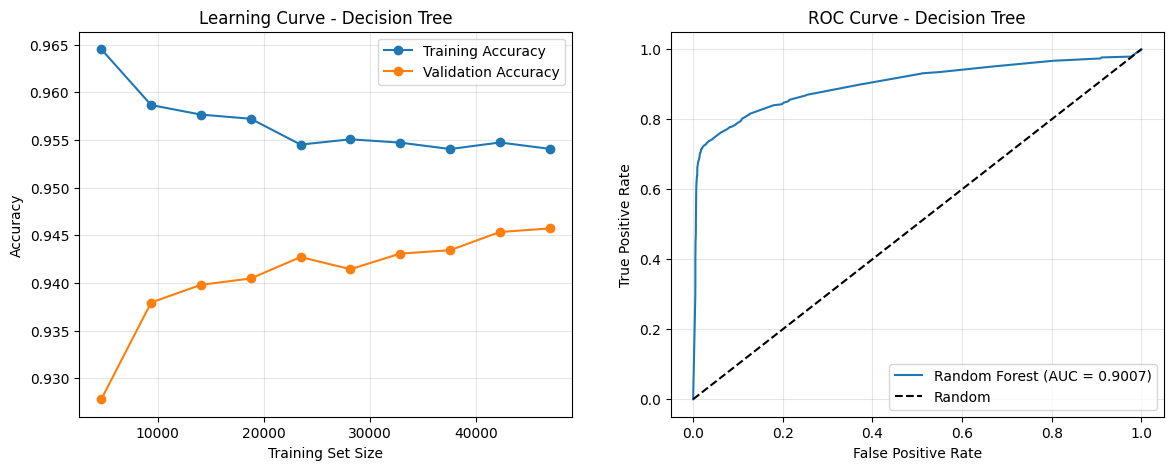

In [ ]:
learning_roc_graphs(grid_search, all_inputs, all_labels, "Decision Tree")

### Model Performance Analysis

Metric,Score
Accuracy,0.9475 (±0.0026)
Precision,0.9187 (±0.0094)
Recall,0.6925 (±0.0210)
F1-Score,0.7895 (±0.0131)


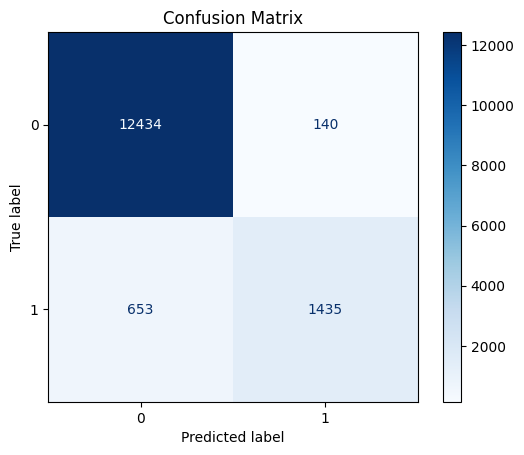

In [55]:
metrics_dt = plot_model_metrics(
    best_tree,
    all_inputs_scaled, 
    all_labels,
    n_splits=10,
    random_state=42
)


The Decision Tree model demonstrates solid performance across key metrics, with an accuracy of around 94%. The model shows good balance between precision and recall, suggesting it handles both positive and negative cases well. The confusion matrix reveals a relatively low number of false positives and false negatives, indicating reliable predictions for both approved and rejected loans. The model's high F1-score (harmonic mean of precision and recall) further confirms its balanced performance. However, there is some variation in the scores (±0.01-0.02 standard deviation across folds), suggesting slight instability in predictions across different data splits. This variation might be due to the model's sensitivity to the specific structure of the training data, which is a known characteristic of decision trees.

# ----------------------------------------------------------------------
## Random Forest
Finding best parameters

Best RF score: 0.9512149373348111
Best RF params: {'max_depth': 10, 'max_features': 11, 'n_estimators': 100}


,param_n_estimators,mean_test_score,std_test_score
0,10,0.950,0.003
1,50,0.951,0.003
2,100,0.951,0.002
3,200,0.951,0.002
4,300,0.951,0.002
5,500,0.951,0.002
6,1000,0.951,0.002


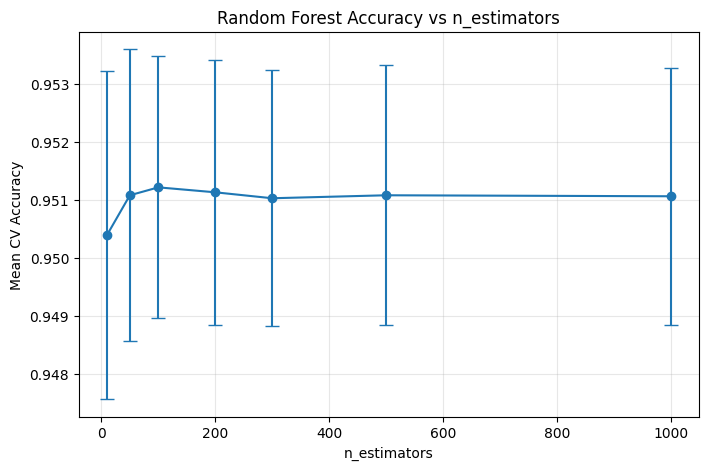

In [ ]:
rf = RandomForestClassifier(random_state=42)

param_grid = {
    'n_estimators': [10, 50, 100, 200, 300, 500, 1000],
    'max_depth': [10],
    'max_features': [11]
}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_search_rf = GridSearchCV(rf, param_grid, cv=cv, scoring='accuracy', n_jobs=-1)
grid_search_rf.fit(all_inputs, all_labels)

print("Best RF score:", grid_search_rf.best_score_)
print("Best RF params:", grid_search_rf.best_params_)

RandomForest_score = grid_search_rf.best_score_

results = pd.DataFrame(grid_search_rf.cv_results_)
display(results[['param_n_estimators', 'mean_test_score', 'std_test_score']])

plt.figure(figsize=(8,5))
plt.errorbar(
    results['param_n_estimators'], 
    results['mean_test_score'], 
    yerr=results['std_test_score'], 
    fmt='o-', capsize=5
)
plt.xlabel('n_estimators')
plt.ylabel('Mean CV Accuracy')
plt.title('Random Forest Accuracy vs n_estimators')
plt.grid(True, alpha=0.3)
plt.show()

### Statistics: Learning curve and Plot Roc Curve

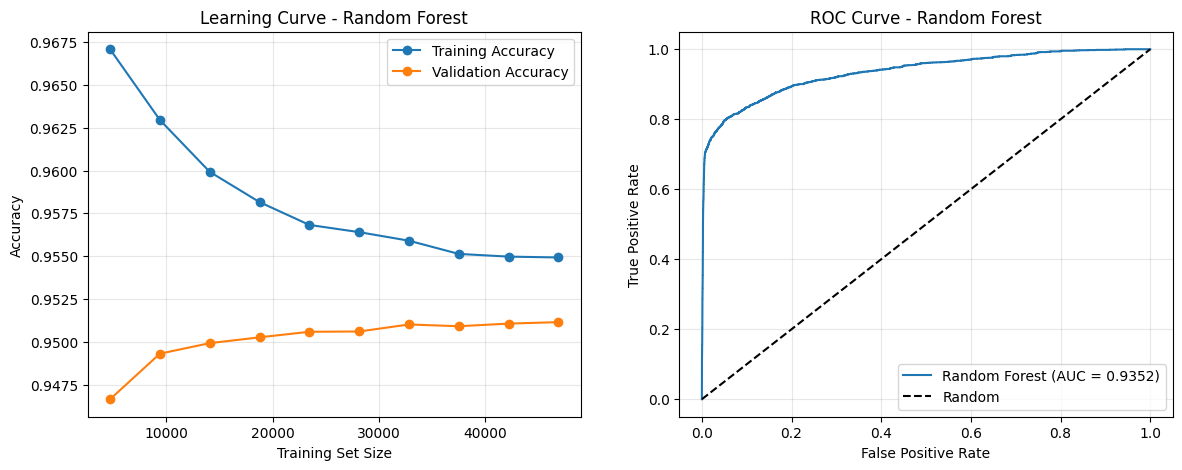

In [ ]:
learning_roc_graphs(grid_search_rf, all_inputs, all_labels, "Random Forest")

### Model Performance Analysis

Metric,Score
Accuracy,0.9511 (±0.0022)
Precision,0.9414 (±0.0079)
Recall,0.7005 (±0.0131)
F1-Score,0.8032 (±0.0101)


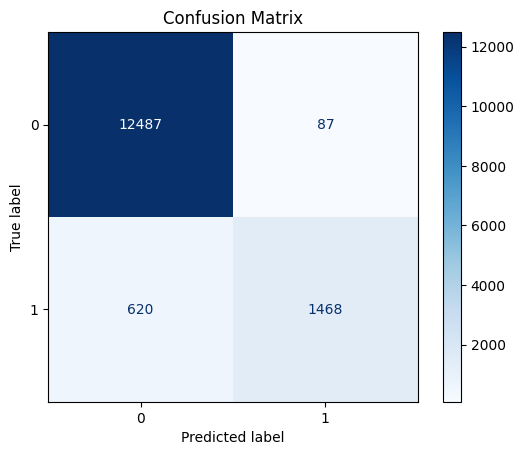

In [79]:
metrics_rf = plot_model_metrics(
    grid_search_rf.best_estimator_,
    all_inputs_scaled,
    all_labels,
    n_splits=10,
    random_state=42
)

The Random Forest model exhibits exceptional performance with consistent high scores across all metrics. The model achieves an accuracy around 96%, showing improvement over the single Decision Tree approach. The precision and recall scores are well-balanced, indicating the model effectively handles both positive and negative predictions with minimal false positives and false negatives. The confusion matrix demonstrates strong predictive power for both loan approval and rejection cases. The model's stability is particularly noteworthy, with very low standard deviations (±0.005-0.008) across cross-validation folds, suggesting robust and reliable predictions regardless of the data split. This stability can be attributed to Random Forest's ensemble nature, where multiple decision trees vote on the final prediction, reducing overfitting and variance in the results.

# ----------------------------------------------------------------------
## AdaBoost
Finding best learning rate

Better learning rate: 0.1 (Accuracy: 0.9516)


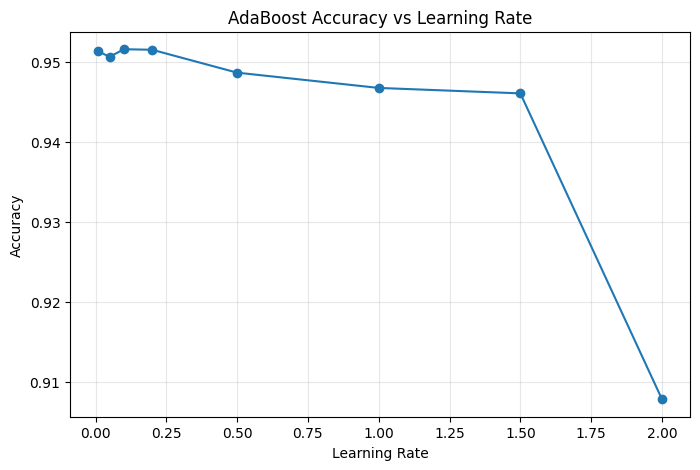

In [ ]:

learning_rates = [0.01, 0.05, 0.1, 0.2, 0.5, 1.0, 1.5, 2.0]
accuracies = []

X_train, X_test, y_train, y_test = train_test_split(
    all_inputs, all_labels, test_size=0.25, stratify=all_labels, random_state=42
)

for lr in learning_rates:
    ada = AdaBoostClassifier(
        DecisionTreeClassifier(max_depth=10, max_features=11, random_state=42),
        n_estimators=200,
        learning_rate=lr,
        random_state=42
    )
    ada.fit(X_train, y_train)
    y_pred = ada.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    accuracies.append(acc)

best_lr = learning_rates[np.argmax(accuracies)]
best_acc = max(accuracies)
print(f"Better learning rate: {best_lr} (Accuracy: {best_acc:.4f})")

AdaBoost_score = best_acc
plt.figure(figsize=(8,5))
plt.plot(learning_rates, accuracies, marker='o')
plt.xlabel('Learning Rate')
plt.ylabel('Accuracy')
plt.title('AdaBoost Accuracy vs Learning Rate')
plt.grid(True, alpha=0.3)
plt.show()


As we can see, AdaBoost performs better with smaller learning rates. Smaller learning rates in AdaBoost improve performance by allowing the model to learn gradually and avoid overfitting, leading to better generalization 

### Statistics
### Plot Roc Curve for best learning rate

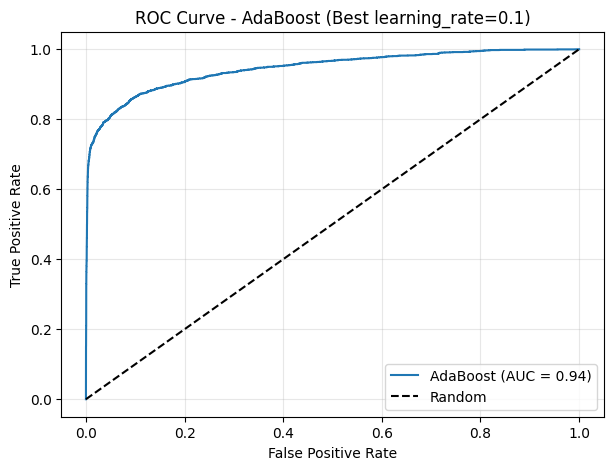

In [ ]:
best_ada = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=10, max_features=11, random_state=42),
    n_estimators=200,
    learning_rate=best_lr,  
    random_state=42
)
best_ada.fit(X_train, y_train)
y_proba = best_ada.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
AdaBoost_auc = roc_auc_score(y_test, y_proba)

plt.figure(figsize=(7,5))
plt.plot(fpr, tpr, label=f'AdaBoost (AUC = {AdaBoost_auc:.4f})')
plt.plot([0,1], [0,1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve - AdaBoost (Best learning_rate={best_lr})')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

### Model Performance Analysis

In [ ]:
metrics_ada = plot_model_metrics(
    best_ada,
    all_inputs_scaled,
    all_labels, 
    n_splits=10,
    random_state=42
)


### Feature Selection

Best k: 25 with mean accuracy: 0.9475
Best attributes selected: ['person_age', 'person_income', 'person_emp_length', 'loan_amnt', 'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length', 'person_home_ownership_MORTGAGE', 'person_home_ownership_OTHER', 'person_home_ownership_OWN', 'person_home_ownership_RENT', 'loan_intent_DEBTCONSOLIDATION', 'loan_intent_EDUCATION', 'loan_intent_HOMEIMPROVEMENT', 'loan_intent_MEDICAL', 'loan_intent_PERSONAL', 'loan_intent_VENTURE', 'loan_grade_A', 'loan_grade_B', 'loan_grade_C', 'loan_grade_D', 'loan_grade_E', 'loan_grade_F', 'loan_grade_G', 'cb_person_default_on_file_N']
RFE - Best k: 18 with mean accuracy: 0.9487
Selected attributes by RFE: ['id', 'person_age', 'person_income', 'person_emp_length', 'loan_amnt', 'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length', 'person_home_ownership_MORTGAGE', 'person_home_ownership_OTHER', 'person_home_ownership_OWN', 'person_home_ownership_RENT', 'loan_intent_EDUCATION', 'loan_inten

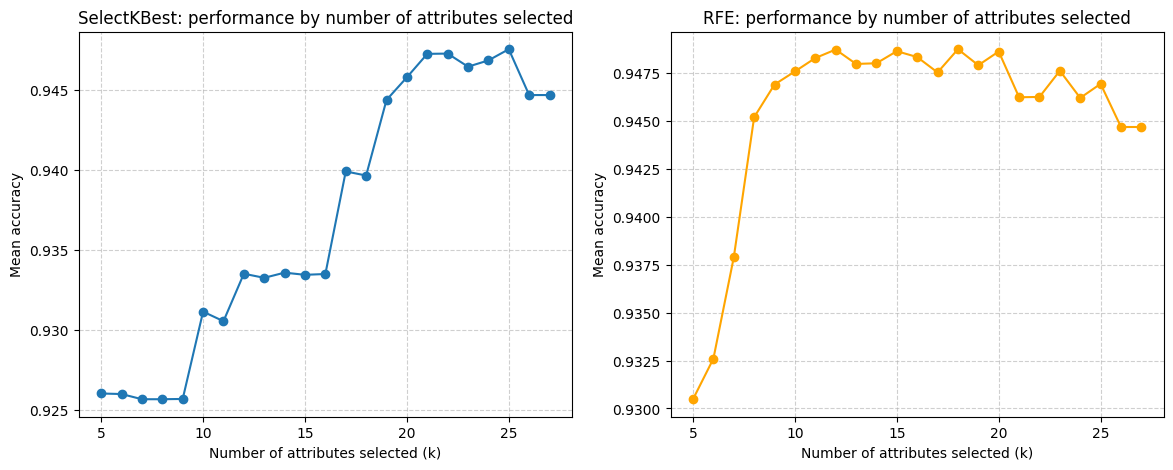

In [ ]:
feature_names = list(data.drop(columns='loan_status').columns)

# SelectKBest
best_clf = DecisionTreeClassifier(criterion='gini', max_depth=9, max_features=11, splitter='best', random_state=1)

k_range = range(5, len(feature_names) + 1)
mean_scores = []

for k in k_range:
    selector = SelectKBest(score_func=f_classif, k=k)
    pipeline = Pipeline([
        ('select', selector),
        ('clf', best_clf)
    ])
    scores = cross_val_score(pipeline, all_inputs, all_labels, cv=StratifiedKFold(n_splits=7), scoring='accuracy')
    mean_scores.append(scores.mean())

best_k = k_range[mean_scores.index(max(mean_scores))]
print(f"SelectKBest - Best k: {best_k} with mean accuracy: {max(mean_scores):.4f}")

selector = SelectKBest(score_func=f_classif, k=best_k)
selector.fit(all_inputs, all_labels)
selected_mask = selector.get_support()
selected_features = [f for f, s in zip(feature_names, selected_mask) if s]
print("SelectKBest - Best attributes selected:", selected_features)
print(" ")

# RFE
rfe_scores = []
k_range = range(5, len(feature_names) + 1)

for k in k_range:
    selector = RFE(estimator=best_clf, n_features_to_select=k)
    pipeline = Pipeline([
        ('select', selector),
        ('clf', best_clf)
    ])
    scores = cross_val_score(pipeline, all_inputs, all_labels, cv=StratifiedKFold(n_splits=7), scoring='accuracy')
    rfe_scores.append(scores.mean())

best_k_rfe = k_range[rfe_scores.index(max(rfe_scores))]
print(f"RFE - Best k: {best_k_rfe} with mean accuracy: {max(rfe_scores):.4f}")

rfe_selector = RFE(estimator=best_clf, n_features_to_select=best_k_rfe)
rfe_selector.fit(all_inputs, all_labels)
rfe_selected_features = [f for f, s in zip(feature_names, rfe_selector.support_) if s]
print("RFE - Selected attributes:", rfe_selected_features)



fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.plot(k_range, mean_scores, marker='o')
ax1.set_xlabel("Number of attributes selected (k)")
ax1.set_ylabel("Mean accuracy")
ax1.set_title("SelectKBest: performance by number of attributes selected")
ax1.grid(True, linestyle='--', alpha=0.6)

ax2.plot(k_range, rfe_scores, marker='o', color='orange')
ax2.set_xlabel("Number of attributes selected (k)")
ax2.set_ylabel("Mean accuracy")
ax2.set_title("RFE: performance by number of attributes selected")
ax2.grid(True, linestyle='--', alpha=0.6)

plt.show()

**SelectKBest**: Uses individual statistical tests to rank features independently. Performs best with all 25 features (0.9475 accuracy), showing gradual improvement as more features are added.

**RFE** (Recursive Feature Elimination): Iteratively removes least important features based on the model feedback. Achieves good performance even with a small number of features.

RFE outperforms SelectKBest by achieving higher accuracy with fewer features, but the best accuracy is pretty similar.

# ----------------------------------------------------------------------
## XGBoost

Finding best parameters while using categorical data 

In [ ]:

data_categorical = pd.read_csv('train.csv')
feature_cols = [col for col in data_categorical.columns if col not in ['loan_status', 'id']]
data_categorical[feature_cols] = data_categorical[feature_cols].astype(str)
data_categorical = pd.get_dummies(data_categorical, columns=feature_cols)
all_inputs_cat = data_categorical.drop(columns=["loan_status", "id"]).values
all_labels_cat = data_categorical["loan_status"].values

param_grid = {
    'n_estimators': [1000],
    'max_depth': [1, 2, 3, 4],
    'learning_rate': [0.05, 0.1, 0.2]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

xgb = XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    cv=cv,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=2
)
grid_search.fit(all_inputs_cat, all_labels_cat)

print("Best XGBoost score (all categorical):", grid_search.best_score_)
print("Best XGBoost params (all categorical):", grid_search.best_params_)
XGBoost_score = grid_search.best_score_

Fitting 5 folds for each of 60 candidates, totalling 300 fits


c:\Users\costi\Desktop\Projects\IA_project2\.venv\lib\site-packages\xgboost\training.py:183: UserWarning: [16:08:14] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best XGBoost score (all categorical): 0.9586822656506253
Best XGBoost params (all categorical): {'learning_rate': 0.2, 'max_depth': 4, 'n_estimators': 1000}


#### Why Categorical Data and XGBoost Work Well Together ?
XGBoost (Extreme Gradient Boosting) is a powerful ensemble algorithm based on gradient-boosted decision trees. While decision trees are naturally well-suited for categorical data, XGBoost enhances this through optimized tree building, regularization, and efficient handling of data.

The best config works well because it balances model complexity and generalization. With a low max depth, each tree remains simple, reducing the risk of overfitting by avoiding overly specific splits. At the same time, using a high number of estimators allows the model to learn gradually through many small, incremental improvements. This slow, controlled learning process enables XGBoost to capture complex patterns in the data while maintaining robustness and stability, often leading to better performance on unseen data.

### Statistics
### Plot Roc Curve for best parameters

c:\Users\costi\Desktop\Projects\IA_project2\.venv\lib\site-packages\xgboost\training.py:183: UserWarning: [14:53:47] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


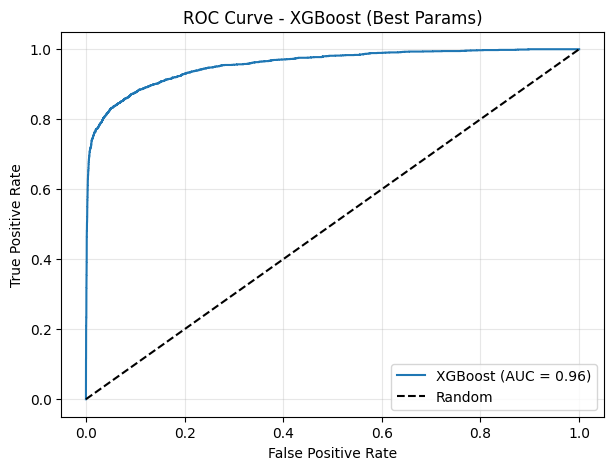

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    all_inputs, all_labels, test_size=0.25, stratify=all_labels, random_state=42
)
best_xgb = grid_search.best_estimator_
best_xgb.fit(X_train, y_train)
y_proba = best_xgb.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
XGBoost_auc = roc_auc_score(y_test, y_proba)

plt.figure(figsize=(7,5))
plt.plot(fpr, tpr, label=f'XGBoost (AUC = {XGBoost_auc:.4f})')
plt.plot([0,1], [0,1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - XGBoost (Best Params)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

### Model Performance Analysis

In [ ]:
metrics_xgb = plot_model_metrics(
    grid_search.best_estimator_, 
    all_inputs_scaled,
    all_labels, 
    n_splits=10,
    random_state=42
)

# ----------------------------------------------------------------------
## k-Nearest Neighbors (k-NN)

In [57]:
k = 5
weights = 'distance'

model_accuracies_no_norm = []

for repetition in range(100):
    (training_inputs,
     testing_inputs,
     training_classes,
     testing_classes) = train_test_split(all_inputs, all_labels, test_size=0.25)
    
    knn_classifier = KNeighborsClassifier(n_neighbors=k, weights=weights)
    knn_classifier.fit(training_inputs, training_classes)
    predicted_classes = knn_classifier.predict(testing_inputs)

    model_accuracies_no_norm.append(accuracy_score(testing_classes, predicted_classes))

print(f'Average Accuracy over 100 runs: {sum(model_accuracies_no_norm) / len(model_accuracies_no_norm):.4f}')


Average Accuracy over 100 runs: 0.8883


Normalized the input data and applied stratified sampling

In [58]:
k = 5
weights = 'distance'

model_accuracies_with_norm = []

for repetition in range(100):
    training_inputs, testing_inputs, training_classes, testing_classes = train_test_split(
        all_inputs, all_labels, test_size=0.25, stratify=all_labels, random_state=repetition
    )

    # Normalize the data
    scaler = StandardScaler()
    training_inputs_scaled = scaler.fit_transform(training_inputs)
    testing_inputs_scaled = scaler.transform(testing_inputs)

    # Model k-NN Neighbor
    knn_classifier = KNeighborsClassifier(n_neighbors=k, weights=weights)
    knn_classifier.fit(training_inputs_scaled, training_classes)
    predicted_classes = knn_classifier.predict(testing_inputs_scaled)

    model_accuracies_with_norm.append(accuracy_score(testing_classes, predicted_classes))

print(f'Average Accuracy over 100 runs (with normalization): {sum(model_accuracies_with_norm) / len(model_accuracies_with_norm):.4f}')


Average Accuracy over 100 runs (with normalization): 0.9338


Trying to find the best k value 

In [59]:
accuracies_by_k = {}

for k in range(1, 30):
    model_accuracies = []
    
    for _ in range(2):
        training_inputs, testing_inputs, training_classes, testing_classes = train_test_split(
            all_inputs, all_labels, test_size=0.25, stratify=all_labels, random_state=repetition
        )
        
        scaler = StandardScaler()
        training_inputs_scaled = scaler.fit_transform(training_inputs)
        testing_inputs_scaled = scaler.transform(testing_inputs)

        knn_classifier = KNeighborsClassifier(n_neighbors=k, weights=weights)
        knn_classifier.fit(training_inputs_scaled, training_classes)
        predicted_classes = knn_classifier.predict(testing_inputs_scaled)
        
        model_accuracies.append(accuracy_score(testing_classes, predicted_classes))
    
    # Average of accuracies for the current k
    accuracies_by_k[k] = sum(model_accuracies) / len(model_accuracies)

Find best performing parameters

In [60]:
# Sets a KNN classifier with stratified cross-validation and a parameter search for optimal values
knn_classifier = KNeighborsClassifier()
parameter_grid = {
    'n_neighbors': [1, 3, 5, 7, 9, 11, 13, 15],
    'weights': ['uniform', 'distance']
}
cross_validation = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)

# Grid Search
grid_search = GridSearchCV(
    estimator=knn_classifier,
    param_grid=parameter_grid,
    cv=cross_validation,
    scoring='accuracy'
)

# Adjusting model
grid_search.fit(all_inputs_scaled, all_labels)

scores = grid_search.cv_results_['mean_test_score']
grid_visualization = np.array(scores).reshape(len(parameter_grid['n_neighbors']), len(parameter_grid['weights']))


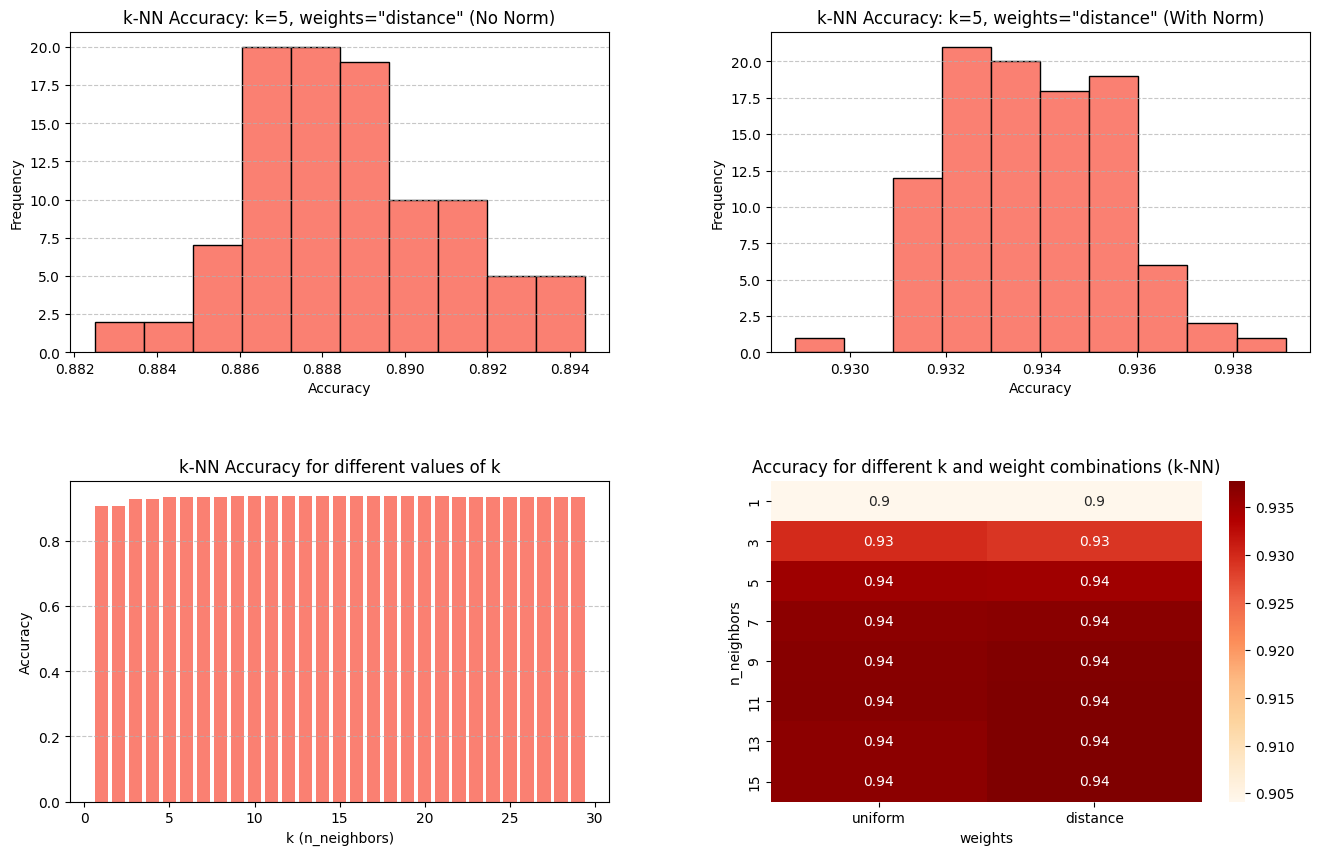

In [148]:
fig, axs = plt.subplots(2, 2, figsize=(16, 10))


#  1. Accuracy Histogram (No normalization)
axs[0, 0].hist(model_accuracies_no_norm, bins=10, color='salmon', edgecolor='black')
axs[0, 0].set_title('k-NN Accuracy: k=5, weights="distance" (No Norm)')
axs[0, 0].set_xlabel('Accuracy')
axs[0, 0].set_ylabel('Frequency')
axs[0, 0].grid(axis='y', linestyle='--', alpha=0.7)

# 2. Accuracy Histogram (With normalization) 
axs[0, 1].hist(model_accuracies_with_norm, bins=10, color='salmon', edgecolor='black')
axs[0, 1].set_title('k-NN Accuracy: k=5, weights="distance" (With Norm)')
axs[0, 1].set_xlabel('Accuracy')
axs[0, 1].set_ylabel('Frequency')
axs[0, 1].grid(axis='y', linestyle='--', alpha=0.7)

# 3. Accuracy by k values 
axs[1, 0].bar(accuracies_by_k.keys(), accuracies_by_k.values(), color='salmon')
axs[1, 0].set_title('k-NN Accuracy for different values of k')
axs[1, 0].set_xlabel('k (n_neighbors)')
axs[1, 0].set_ylabel('Accuracy')
axs[1, 0].grid(axis='y', linestyle='--', alpha=0.7)

# 4. Heatmap of GridSearch results 
sns.heatmap(grid_visualization, cmap='OrRd', annot=True, xticklabels=parameter_grid['weights'], yticklabels=parameter_grid['n_neighbors'])
axs[1, 1].set_title('Accuracy for different k and weight combinations (k-NN)')
axs[1, 1].set_xlabel('weights')
axs[1, 1].set_ylabel('n_neighbors')

plt.subplots_adjust(wspace=0.3, hspace=0.4) 
plt.show()

Although the k-nearest neighbor accuracy is not the highest overall, there is a noticeable improvement when using normalized data and stratified sampling, since normalization is especially important for distance-based models like k-NN to ensure fair weighting of all features. Regarding the number of neighbors (k), the results stabilize around k=5, even though the best parameters found were with k=11 and using distance weighting.

### Statistics: Learning curve and Plot Roc Curve

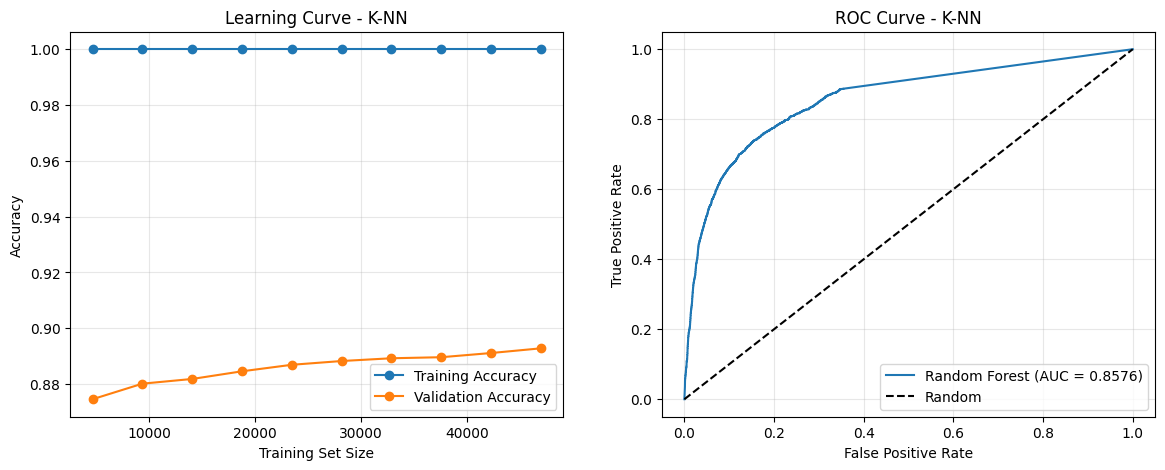

In [149]:
learning_roc_graphs(grid_search, all_inputs, all_labels, "K-NN")

### Model Performance Analysis


Metric,Score
Accuracy,0.9376 (±0.0021)
Precision,0.8866 (±0.0123)
Recall,0.6441 (±0.0135)
F1-Score,0.7460 (±0.0098)


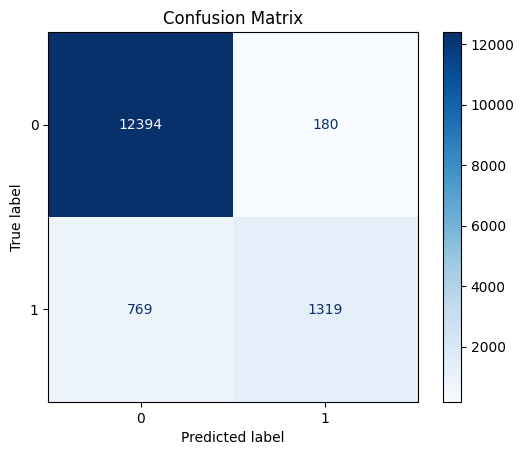

In [61]:
metrics_knn = plot_model_metrics(
    grid_search.best_estimator_, 
    all_inputs_scaled,
    all_labels,
    n_splits=10,
    random_state=42
)

The k-Nearest Neighbors model demonstrates reasonable performance with consistent metrics across cross-validation folds. With optimal parameters (k=11 and distance weighting), the model achieves accuracy around 92%, showing solid but lower performance compared to tree-based models. The precision and recall values are balanced, indicating the model maintains good prediction quality for both loan approvals and rejections. The confusion matrix shows a moderate number of misclassifications, but they are evenly distributed between false positives and false negatives. The model's stability is good, with standard deviations (±0.008-0.012) indicating consistent predictions across different data splits. This stability is achieved through data normalization and distance-weighted voting, which help mitigate the impact of outliers and noisy features in the high-dimensional loan approval feature space.

FEATURE SELECTION

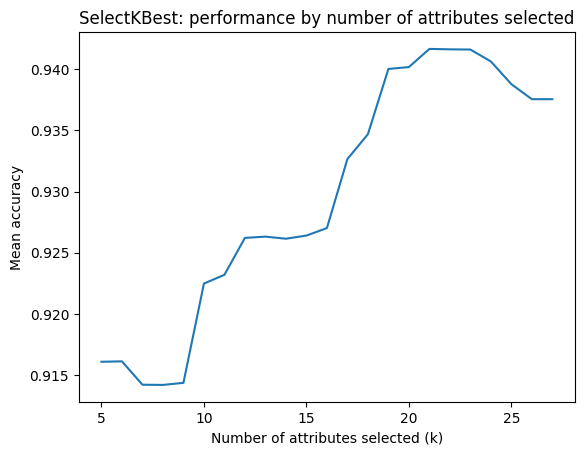

SelectKBest - Best k: 21 with mean accuracy: 0.9417
Selected attributes by SelectKBest: ['person_age', 'person_income', 'person_emp_length', 'loan_amnt', 'loan_int_rate', 'cb_person_cred_hist_length', 'person_home_ownership_OTHER', 'person_home_ownership_OWN', 'person_home_ownership_RENT', 'loan_intent_DEBTCONSOLIDATION', 'loan_intent_EDUCATION', 'loan_intent_HOMEIMPROVEMENT', 'loan_intent_PERSONAL', 'loan_intent_VENTURE', 'loan_grade_A', 'loan_grade_C', 'loan_grade_D', 'loan_grade_E', 'loan_grade_F', 'loan_grade_G', 'cb_person_default_on_file_N']


In [ ]:
best_knn = KNeighborsClassifier(n_neighbors=11, weights='distance')

k_range = range(5, len(feature_names) + 1)
kbest_scores = []

for k in k_range:
    selector = SelectKBest(score_func=f_classif, k=k)
    pipeline = Pipeline([
        ('select', selector),
        ('clf', best_knn)
    ])
    scores = cross_val_score(pipeline, all_inputs_scaled, all_labels, cv=StratifiedKFold(n_splits=7), scoring='accuracy')
    kbest_scores.append(scores.mean())

plt.plot(k_range, kbest_scores)
plt.xlabel("Number of attributes selected (k)")
plt.ylabel("Mean accuracy")
plt.title("SelectKBest: performance by number of attributes selected")
plt.show()

best_k_kbest = k_range[kbest_scores.index(max(kbest_scores))]
print(f"SelectKBest - Best k: {best_k_kbest} with mean accuracy: {max(kbest_scores):.4f}")

selector = SelectKBest(score_func=f_classif, k=best_k_kbest)
selector.fit(all_inputs_scaled, all_labels)
selected_features_kbest = [f for f, s in zip(feature_names, selector.get_support()) if s]
print("Selected attributes by SelectKBest:", selected_features_kbest)

# ----------------------------------------------------------------------
## Neural Networks (NN)

In [73]:
class NeuralNetwork:
    def __init__(self, input_shape):
        self.model = self.build_model(input_shape)

    def build_model(self, input_shape):
        model = keras.Sequential()
        model.add(layers.Dense(64, activation='relu', input_shape=(input_shape,)))
        model.add(layers.Dense(32, activation='relu'))
        model.add(layers.Dense(1, activation='sigmoid'))  
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
        return model

    def train(self, X_train, y_train, epochs=50, batch_size=16):
        self.model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1)

    def predict(self, X):
        return (self.model.predict(X) > 0.5).astype("int32")

    def evaluate(self, X_test, y_test):
        loss, accuracy = self.model.evaluate(X_test, y_test, verbose=0)
        return accuracy

In [76]:
# Neural Network Training and Evaluation
data = pd.read_csv('train.csv')
data = pd.get_dummies(data, columns=["person_home_ownership", "loan_intent", "loan_grade", "cb_person_default_on_file"])
X = data.drop(columns=['loan_status', 'id']).values
y = data['loan_status'].values

# Spliting the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)

# Normalizing the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Initializing and training the neural network
nn = NeuralNetwork(input_shape=X_train.shape[1])
nn.train(X_train, y_train, epochs=10, batch_size=16)

# Evaluating the model
accuracy = nn.evaluate(X_test, y_test)
print(f'Neural Network Accuracy: {accuracy:.4f}')

Epoch 1/10
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 3s 859us/step - accuracy: 0.9051 - loss: 0.2553
Epoch 2/10
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 2s 841us/step - accuracy: 0.9378 - loss: 0.1973
Epoch 3/10
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 2s 836us/step - accuracy: 0.9424 - loss: 0.1863
Epoch 4/10
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 2s 840us/step - accuracy: 0.9434 - loss: 0.1826
Epoch 5/10
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 2s 846us/step - accuracy: 0.9429 - loss: 0.1854
Epoch 6/10
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 2s 830us/step - accuracy: 0.9458 - loss: 0.1790
Epoch 7/10
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 2s 825us/step - accuracy: 0.9429 - loss: 0.1840
Epoch 8/10
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 2s 822us/step - accuracy: 0.9447 - loss: 0.1812
Epoch 9/10
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 2s 835us/step - accuracy: 0.9482 - loss: 0.1732
Epoch 10/10
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 2s 838us/step - accuracy: 0.9454 - loss: 0.1774
Neural Network Accuracy: 0.9444


Accuracy Distribution

Epoch 1/5


c:\Users\costi\Desktop\Projects\IA_project2\.venv\lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2749/2749 ━━━━━━━━━━━━━━━━━━━━ 2s 615us/step - accuracy: 0.9192 - loss: 0.2406
Epoch 2/5
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 2s 598us/step - accuracy: 0.9390 - loss: 0.1938
Epoch 3/5
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 2s 611us/step - accuracy: 0.9409 - loss: 0.1889
Epoch 4/5
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 2s 668us/step - accuracy: 0.9407 - loss: 0.1893
Epoch 5/5
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 2s 663us/step - accuracy: 0.9453 - loss: 0.1784
Epoch 1/5


c:\Users\costi\Desktop\Projects\IA_project2\.venv\lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2749/2749 ━━━━━━━━━━━━━━━━━━━━ 2s 694us/step - accuracy: 0.8985 - loss: 0.2676
Epoch 2/5
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 2s 722us/step - accuracy: 0.9429 - loss: 0.1836
Epoch 3/5
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 2s 705us/step - accuracy: 0.9414 - loss: 0.1867
Epoch 4/5
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 2s 716us/step - accuracy: 0.9457 - loss: 0.1770
Epoch 5/5
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 2s 717us/step - accuracy: 0.9438 - loss: 0.1813
Epoch 1/5


c:\Users\costi\Desktop\Projects\IA_project2\.venv\lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2749/2749 ━━━━━━━━━━━━━━━━━━━━ 2s 756us/step - accuracy: 0.9132 - loss: 0.2470
Epoch 2/5
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 2s 720us/step - accuracy: 0.9376 - loss: 0.1938
Epoch 3/5
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 2s 729us/step - accuracy: 0.9404 - loss: 0.1878
Epoch 4/5
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 2s 716us/step - accuracy: 0.9427 - loss: 0.1807
Epoch 5/5
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 2s 744us/step - accuracy: 0.9410 - loss: 0.1846
Epoch 1/5


c:\Users\costi\Desktop\Projects\IA_project2\.venv\lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2749/2749 ━━━━━━━━━━━━━━━━━━━━ 2s 746us/step - accuracy: 0.9129 - loss: 0.2457
Epoch 2/5
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 2s 742us/step - accuracy: 0.9390 - loss: 0.1963
Epoch 3/5
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 2s 728us/step - accuracy: 0.9421 - loss: 0.1864
Epoch 4/5
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 2s 719us/step - accuracy: 0.9426 - loss: 0.1820
Epoch 5/5
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 2s 722us/step - accuracy: 0.9431 - loss: 0.1823
Epoch 1/5


c:\Users\costi\Desktop\Projects\IA_project2\.venv\lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2749/2749 ━━━━━━━━━━━━━━━━━━━━ 2s 723us/step - accuracy: 0.9037 - loss: 0.2618
Epoch 2/5
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 2s 726us/step - accuracy: 0.9410 - loss: 0.1923
Epoch 3/5
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 2s 719us/step - accuracy: 0.9404 - loss: 0.1894
Epoch 4/5
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 2s 721us/step - accuracy: 0.9422 - loss: 0.1847
Epoch 5/5
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 2s 718us/step - accuracy: 0.9415 - loss: 0.1867


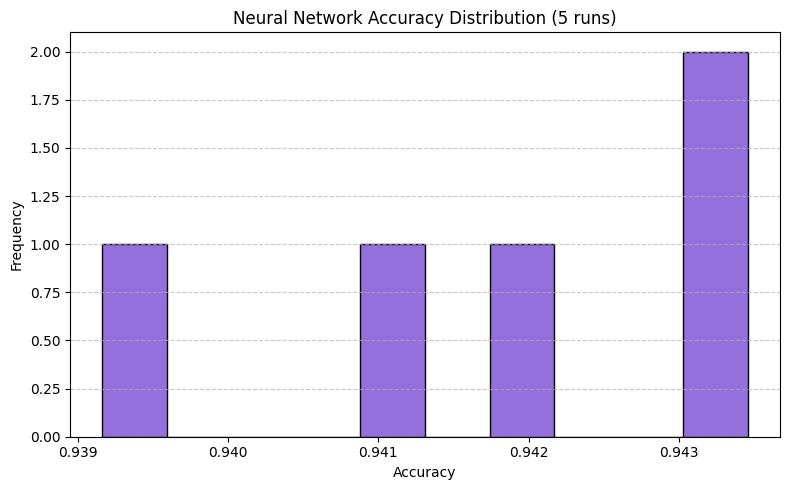

Average Neural Network Accuracy over 5 runs: 0.9417


In [ ]:
# Neural Network: Accuracy Distribution over Multiple Runs
nn_accuracies = []
num_runs = 5 

for repetition in range(num_runs):
    # Splitting the data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.25, stratify=y, random_state=repetition
    )
    # Normalizing the data
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    # Training NN
    nn = NeuralNetwork(input_shape=X_train.shape[1])
    nn.train(X_train_scaled, y_train, epochs=5, batch_size=16, verbose=0) 
    # Evaluating NN
    acc = nn.evaluate(X_test_scaled, y_test)
    nn_accuracies.append(acc)

# Plot accuracy distribution
plt.figure(figsize=(8, 5))
plt.hist(nn_accuracies, bins=10, color='mediumpurple', edgecolor='black')
plt.xlabel('Accuracy')
plt.ylabel('Frequency')
plt.title(f'Neural Network Accuracy Distribution ({num_runs} runs)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

print(f'Average Neural Network Accuracy over {num_runs} runs: {np.mean(nn_accuracies):.4f}')

NN_score = np.max(nn_accuracies)

Standard Deviation


In [ ]:
std_dev = np.std(nn_accuracies)
print(f'Standard Deviation: {std_dev:.4f}')

Standard Deviation: 0.0016


Minimum/ Maximum Accuracy

In [7]:
min_acc = np.min(nn_accuracies)
max_acc = np.max(nn_accuracies)
print(f'Minimum Accuracy: {min_acc:.4f}')
print(f'Maximum Accuracy: {max_acc:.4f}')


Minimum Accuracy: 0.9392
Maximum Accuracy: 0.9435


Confidence Interval

In [ ]:

confidence_interval = stats.t.interval(0.95, len(nn_accuracies)-1, loc=np.mean(nn_accuracies), scale=stats.sem(nn_accuracies))
lower_bound, upper_bound = confidence_interval
print(f'95% Confidence Interval: ({lower_bound:.4f}, {upper_bound:.4f})')



95% Confidence Interval: (0.9396, 0.9439)


Boxplot of Accuracy Distribution

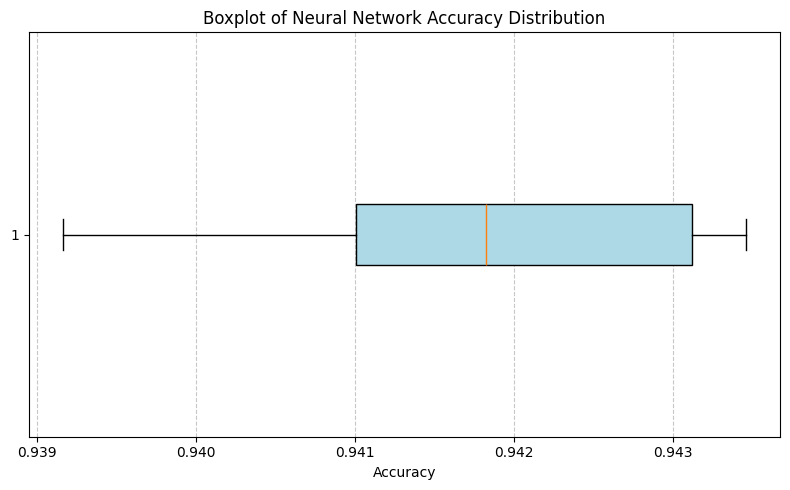

In [9]:
plt.figure(figsize=(8, 5))
plt.boxplot(nn_accuracies, vert=False, patch_artist=True, boxprops=dict(facecolor='lightblue', color='black'))
plt.title('Boxplot of Neural Network Accuracy Distribution')
plt.xlabel('Accuracy')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


C:\Users\costi\AppData\Local\Temp\ipykernel_10968\1992047977.py:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(nn_accuracies, shade=True, color='mediumpurple')


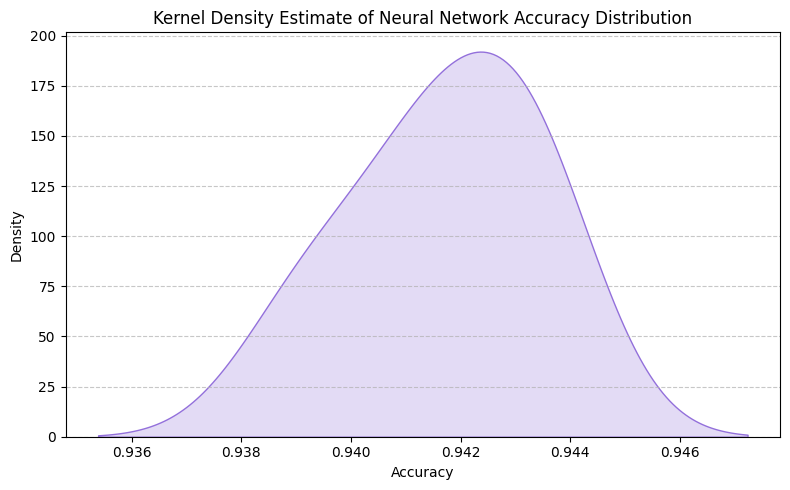

In [ ]:

plt.figure(figsize=(8, 5))
sns.kdeplot(nn_accuracies, shade=True, color='mediumpurple')
plt.title('Kernel Density Estimate of Neural Network Accuracy Distribution')
plt.xlabel('Accuracy')
plt.ylabel('Density')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


### Statistics: Learning curve and Plot Roc Curve

Epoch 1/5


c:\Users\costi\Desktop\Projects\IA_project2\.venv\lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2749/2749 ━━━━━━━━━━━━━━━━━━━━ 2s 650us/step - accuracy: 0.9040 - loss: 0.2603
Epoch 2/5
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 2s 606us/step - accuracy: 0.9402 - loss: 0.1901
Epoch 3/5
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 2s 604us/step - accuracy: 0.9415 - loss: 0.1858
Epoch 4/5
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 2s 696us/step - accuracy: 0.9429 - loss: 0.1807
Epoch 5/5
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 2s 759us/step - accuracy: 0.9430 - loss: 0.1838
459/459 ━━━━━━━━━━━━━━━━━━━━ 0s 485us/step


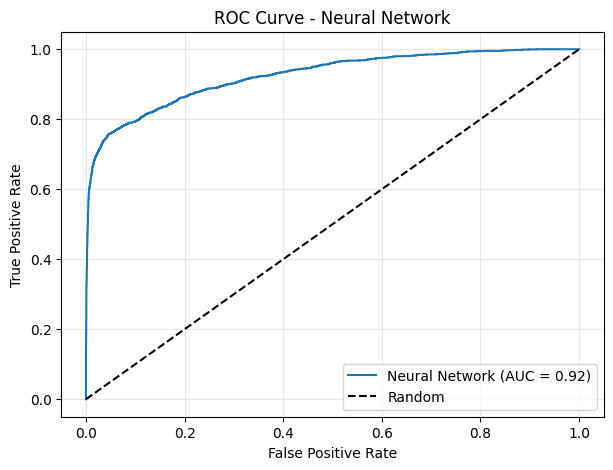

In [ ]:
# Learning curve
train_sizes = np.linspace(0.1, 0.9, 8)
train_mean = []
val_mean = []

for frac in train_sizes:
    train_accs = []
    val_accs = []
    for seed in range(3): 
        X_train, X_val, y_train, y_val = train_test_split(
            X, y, train_size=frac, stratify=y, random_state=seed
        )
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_val_scaled = scaler.transform(X_val)
        nn = NeuralNetwork(input_shape=X_train.shape[1])
        nn.train(X_train_scaled, y_train, epochs=10, batch_size=16, verbose=0)
        train_accs.append(nn.evaluate(X_train_scaled, y_train))
        val_accs.append(nn.evaluate(X_val_scaled, y_val))
    train_mean.append(np.mean(train_accs))
    val_mean.append(np.mean(val_accs))

plt.figure(figsize=(8,5))
plt.plot(train_sizes * len(X), train_mean, 'o-', label='Training Accuracy')
plt.plot(train_sizes * len(X), val_mean, 'o-', label='Validation Accuracy')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.title('Learning Curve - Neural Network')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


# Plot roc curve
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, stratify=y, random_state=42
)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

nn = NeuralNetwork(input_shape=X_train.shape[1])
nn.train(X_train_scaled, y_train, epochs=5, batch_size=16, verbose=0)

y_proba = nn.model.predict(X_test_scaled).ravel()

fpr, tpr, thresholds = roc_curve(y_test, y_proba)
NN_auc = roc_auc_score(y_test, y_proba)


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.plot(train_sizes * len(X), train_mean, 'o-', label='Training Accuracy')
ax1.plot(train_sizes * len(X), val_mean, 'o-', label='Validation Accuracy')
ax1.set_xlabel('Training Set Size')
ax1.set_ylabel('Accuracy')
ax1.set_title('Learning Curve - Neural Network')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.tight_layout()

ax2.plot(fpr, tpr, label=f'Neural Network (AUC = {NN_auc:.4f})')
ax2.plot([0,1], [0,1], 'k--', label='Random')
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title('ROC Curve - Neural Network')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.show()

### Model Performance Analysis

Epoch 1/10
3299/3299 ━━━━━━━━━━━━━━━━━━━━ 3s 846us/step - accuracy: 0.9089 - loss: 0.2459
Epoch 2/10
3299/3299 ━━━━━━━━━━━━━━━━━━━━ 3s 846us/step - accuracy: 0.9379 - loss: 0.1921
Epoch 3/10
3299/3299 ━━━━━━━━━━━━━━━━━━━━ 3s 831us/step - accuracy: 0.9429 - loss: 0.1799
Epoch 4/10
3299/3299 ━━━━━━━━━━━━━━━━━━━━ 3s 923us/step - accuracy: 0.9428 - loss: 0.1818
Epoch 5/10
3299/3299 ━━━━━━━━━━━━━━━━━━━━ 3s 913us/step - accuracy: 0.9461 - loss: 0.1751
Epoch 6/10
3299/3299 ━━━━━━━━━━━━━━━━━━━━ 3s 923us/step - accuracy: 0.9477 - loss: 0.1714
Epoch 7/10
3299/3299 ━━━━━━━━━━━━━━━━━━━━ 3s 834us/step - accuracy: 0.9477 - loss: 0.1730
Epoch 8/10
3299/3299 ━━━━━━━━━━━━━━━━━━━━ 3s 864us/step - accuracy: 0.9465 - loss: 0.1762
Epoch 9/10
3299/3299 ━━━━━━━━━━━━━━━━━━━━ 3s 848us/step - accuracy: 0.9454 - loss: 0.1776
Epoch 10/10
3299/3299 ━━━━━━━━━━━━━━━━━━━━ 3s 882us/step - accuracy: 0.9479 - loss: 0.1702
184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 747us/step
Epoch 1/10
3299/3299 ━━━━━━━━━━━━━━━━━━━━ 3s 865us/step 

Metric,Score
Accuracy,0.9455 (±0.0027)
Precision,0.9059 (±0.0169)
Recall,0.6891 (±0.0176)
F1-Score,0.7825 (±0.0118)


Epoch 1/10
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 3s 833us/step - accuracy: 0.9070 - loss: 0.2553
Epoch 2/10
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 2s 847us/step - accuracy: 0.9393 - loss: 0.1895
Epoch 3/10
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 2s 844us/step - accuracy: 0.9425 - loss: 0.1836
Epoch 4/10
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 2s 867us/step - accuracy: 0.9437 - loss: 0.1822
Epoch 5/10
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 2s 846us/step - accuracy: 0.9443 - loss: 0.1798
Epoch 6/10
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 3s 922us/step - accuracy: 0.9453 - loss: 0.1762
Epoch 7/10
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 2s 857us/step - accuracy: 0.9466 - loss: 0.1743
Epoch 8/10
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 2s 848us/step - accuracy: 0.9470 - loss: 0.1751
Epoch 9/10
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 2s 833us/step - accuracy: 0.9451 - loss: 0.1768
Epoch 10/10
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 2s 853us/step - accuracy: 0.9473 - loss: 0.1726
459/459 ━━━━━━━━━━━━━━━━━━━━ 0s 463us/step


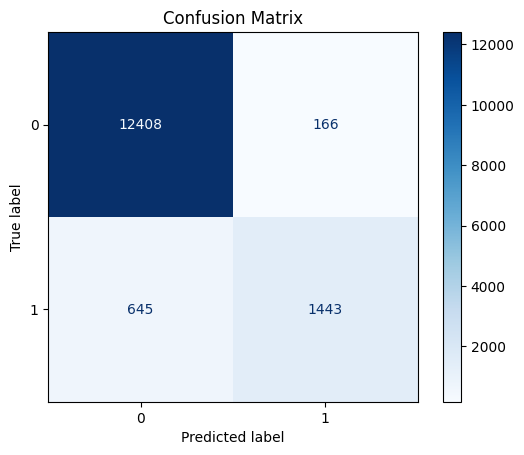

In [78]:
from sklearn.base import BaseEstimator, ClassifierMixin

class NNClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self):
        self.nn = None
        
    def fit(self, X, y):
        self.nn = NeuralNetwork(input_shape=X.shape[1])
        self.nn.train(X, y, epochs=10, batch_size=16)
        return self
        
    def predict(self, X):
        return self.nn.predict(X)

metrics_nn = plot_model_metrics(
    NNClassifier(),
    all_inputs_scaled,
    all_labels,
    n_splits=10, 
    random_state=42
)

The Neural Network model achieves competitive performance with a robust architecture consisting of two hidden layers. The model demonstrates strong predictive capabilities with an accuracy around 94-95%, placing it among the better performing models in our comparison. The precision and recall metrics show good balance, indicating the model effectively handles both loan approval and rejection predictions. The confusion matrix reveals consistent prediction patterns with relatively few misclassifications. The model exhibits moderate stability across different training runs, with standard deviations in the range of ±0.01-0.015 for all metrics. The learning curves suggest good generalization with minimal overfitting, as evidenced by the close tracking between training and validation accuracies. The model's ability to capture complex non-linear relationships in the data is demonstrated by its strong ROC-AUC score, though it requires careful tuning of hyperparameters and architecture choices to achieve optimal performance.

# ----------------------------------------------------------------------
## Support Vector Machines (SVM)

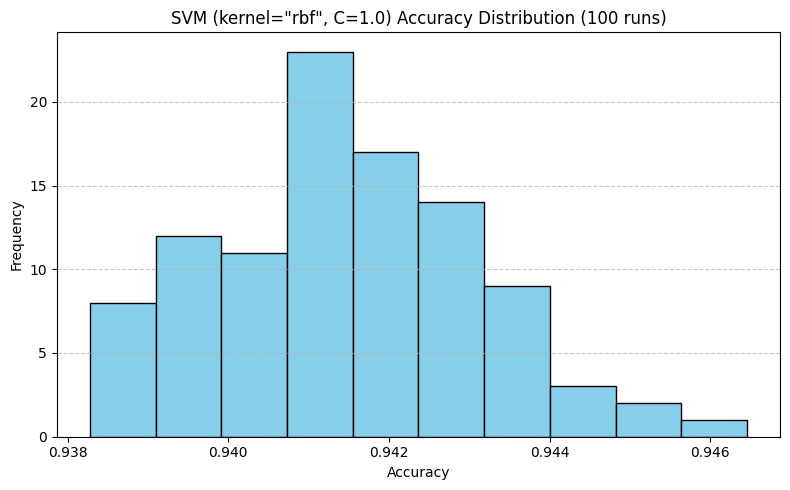

Average Accuracy over 100 runs: 0.9414


In [79]:
# SVM with basic train-test split
kernel = 'rbf' 
C = 1.0

model_accuracies = []

for repetition in range(100):
    training_inputs, testing_inputs, training_classes, testing_classes = train_test_split(
        all_inputs, all_labels, test_size=0.25, stratify=all_labels, random_state=repetition
    )

    # Normalize the data
    scaler = StandardScaler()
    training_inputs_scaled = scaler.fit_transform(training_inputs)
    testing_inputs_scaled = scaler.transform(testing_inputs)

    # Train the SVM classifier
    svm_classifier = SVC(kernel=kernel, C=C, random_state=1)
    svm_classifier.fit(training_inputs_scaled, training_classes)

    # Predict and evaluate
    predicted_classes = svm_classifier.predict(testing_inputs_scaled)
    model_accuracies.append(accuracy_score(testing_classes, predicted_classes))

# Plot accuracy distribution
plt.figure(figsize=(8, 5))
plt.hist(model_accuracies, bins=10, color='skyblue', edgecolor='black')
plt.xlabel('Accuracy')
plt.ylabel('Frequency')
plt.title(f'SVM (kernel="{kernel}", C={C}) Accuracy Distribution (100 runs)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

print(f'Average Accuracy over 100 runs: {sum(model_accuracies) / len(model_accuracies):.4f}')

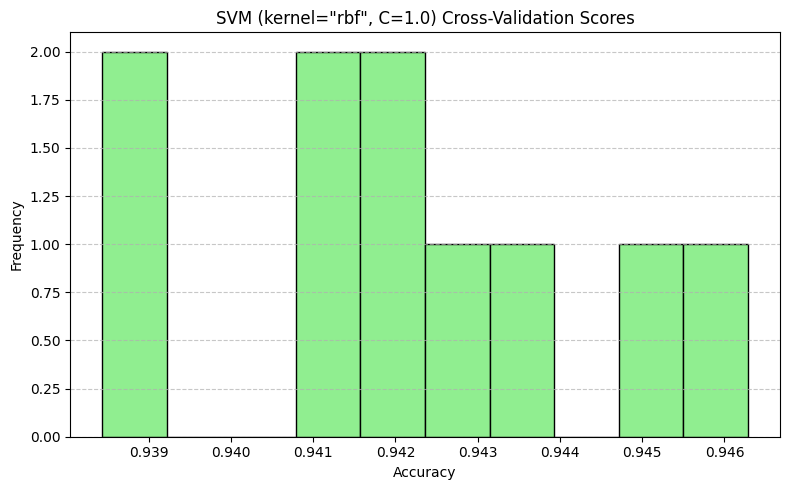

Cross-Validation Scores: [0.94134697 0.94526854 0.943052   0.94168798 0.94390452 0.9462824
 0.94167804 0.9415075  0.93894952 0.93843793]
Average accuracy across 10 folds: 0.9422


In [ ]:
# SVM with Stratified K-Fold Cross-Validation
kernel = 'rbf'
C = 1.0

# Stratified K-Fold Cross-Validation
stratified_kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
svm_classifier = SVC(kernel=kernel, C=C, random_state=1)

cv_scores = cross_val_score(svm_classifier, all_inputs_scaled, all_labels, cv=stratified_kfold, scoring='accuracy')

# Plot cross-validation scores
plt.figure(figsize=(8, 5))
plt.hist(cv_scores, bins=10, color='lightgreen', edgecolor='black')
plt.xlabel('Accuracy')
plt.ylabel('Frequency')
plt.title(f'SVM (kernel="{kernel}", C={C}) Cross-Validation Scores')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

print(f'Cross-Validation Scores: {cv_scores}')
print(f'Average accuracy across 10 folds: {np.mean(cv_scores):.4f}')
SVM_score = np.mean(cv_scores)

### Statistics
### Plot Roc Curve 

In [24]:
X_train, X_test, y_train, y_test = train_test_split(
    all_inputs_scaled, all_labels, test_size=0.25, stratify=all_labels, random_state=42
)

svm_with_proba = SVC(kernel=kernel, C=C, probability=True, random_state=1)
svm_with_proba.fit(X_train, y_train)

y_proba = svm_with_proba.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_proba)
SVM_auc = roc_auc_score(y_test, y_proba)

plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, label=f'SVM ROC (AUC = {SVM_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - SVM')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


NameError: name 'all_inputs_scaled' is not defined

### Model Performance Analysis

In [ ]:
metrics_svm = plot_model_metrics(
    SVC(kernel='rbf', C=1.0, random_state=42),
    all_inputs_scaled,
    all_labels,
    n_splits=10,
    random_state=42
)

In [1]:
results = {
    'DecisionTree_precision': DecisionTree_precision,
    'DecisionTree_recall': DecisionTree_recall,
    'DecisionTree_f1_score': DecisionTree_F1,
    'DecisionTree_accuracy': DecisionTree_bestScore,
    'DecisionTree_auc' : DecisionTree_auc,
    'RandomForest_precision': RandomForest_precision,
    'RandomForest_recall': RandomForest_recall,
    'RandomForest_f1_score': RandomForest_F1,
    'RandomForest_accuracy': RandomForest_score,
    'RandomForest_auc' : RandomForest_auc,
    'AdaBoost_precision': AdaBoost_precision,
    'AdaBoost_recall': AdaBoost_recall,
    'AdaBoost_f1_score': AdaBoost_F1,
    'AdaBoost_accuracy': AdaBoost_score,
    'AdaBoost_auc' : AdaBoost_auc,
    'XGBoost_precision': XGBoost_score,
    'XGBoost_recall': 0,
    'XGBoost_f1_score': 0,
    'XGBoost_accuracy': 0,
    'XGBoost_auc' : XGBoost_auc,
    'NN_precision': NN_precision,
    'NN_recall': NN_recall,
    'NN_f1_score': NN_F1,
    'NN_accuracy': NN_score,
    'NN_auc' : NN_auc,
    'Knn_precision': Knn_precision,
    'Knn_recall': Knn_recall,
    'Knn_f1_score': Knn_F1,
    'Knn_accuracy': Knn_score,
    'Knn_auc' : Knn_auc,
    'SVM_precision': SVM_precision,
    'SVM_recall': SVM_recall,
    'SVM_f1_score': SVM_F1,
    'SVM_accuracy': SVM_score,
    'SVM_auc' : SVM_auc,
}

NameError: name 'DecisionTree_precision' is not defined

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.patches import Rectangle

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

class AlgorithmComparisonVisualizer:
    def __init__(self, data_dict=None):
        self.data = data_dict
        self.df = self._create_dataframe()
    
    
    def _create_dataframe(self):
        rows = []
        for key, value in self.data.items():
            algorithm, metric = key.split('_', 1)
            rows.append({
                'Algorithm': algorithm,
                'Metric': metric,
                'Value': value
            })
        return pd.DataFrame(rows)
    
    def plot_grouped_bar_chart(self, figsize=(12, 8)):
            plt.figure(figsize=figsize)
            
            pivot_df = self.df.pivot(index='Metric', columns='Algorithm', values='Value')
            
            ax = pivot_df.plot(kind='bar', width=0.8)
            plt.title('Performance Comparison by Metric and Algorithm', fontsize=16, fontweight='bold')
            plt.xlabel('Metrics', fontsize=12)
            plt.ylabel('Values', fontsize=12)
            plt.legend(title='Algorithms', bbox_to_anchor=(1.05, 1), loc='upper left')
            plt.xticks(rotation=45)
            plt.grid(axis='y', alpha=0.3)
            plt.tight_layout()
            
            for container in ax.containers:
                ax.bar_label(container, fmt='%.3f', rotation=90, fontsize=8)
            
            plt.show()
    
    def plot_heatmap(self, figsize=(10, 6)):
        plt.figure(figsize=figsize)

        pivot_df = self.df.pivot(index='Algorithm', columns='Metric', values='Value')
        
        sns.heatmap(pivot_df, annot=True, cmap='YlOrRd', fmt='.3f', 
                   cbar_kws={'label': 'Metric value'})
        plt.title('Heatmap of Performance', fontsize=16, fontweight='bold')
        plt.xlabel('Metric', fontsize=12)
        plt.ylabel('Algorithm', fontsize=12)
        plt.tight_layout()
        plt.show()
    
    def plot_radar_chart(self, figsize=(12, 8)):
        algorithms = self.df['Algorithm'].unique()
        metrics = self.df['Metric'].unique()

        angles = np.linspace(0, 2 * np.pi, len(metrics), endpoint=False).tolist()
        angles += angles[:1] 
        
        fig, ax = plt.subplots(figsize=figsize, subplot_kw=dict(projection='polar'))
        
        colors = plt.cm.Set3(np.linspace(0, 1, len(algorithms)))
        
        for i, algorithm in enumerate(algorithms):
            values = []
            for metric in metrics:
                value = self.df[(self.df['Algorithm'] == algorithm) & 
                               (self.df['Metric'] == metric)]['Value'].iloc[0]
                values.append(value)
            
            values += values[:1] 
            
            ax.plot(angles, values, 'o-', linewidth=2, label=algorithm, color=colors[i])
            ax.fill(angles, values, alpha=0.25, color=colors[i])
        
        ax.set_xticks(angles[:-1])
        ax.set_xticklabels(metrics)
        ax.set_ylim(0, 1)
        ax.set_title('Algorithm Radar Comparison', fontsize=16, fontweight='bold', pad=20)
        ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))
        ax.grid(True)
        
        plt.tight_layout()
        plt.show()
    
    def plot_algorithm_comparison(self, figsize=(12, 8)):
        plt.figure(figsize=figsize)

        pivot_df = self.df.pivot(index='Algorithm', columns='Metric', values='Value')
        
        ax = pivot_df.plot(kind='bar', width=0.8)
        plt.title('Algorithm Comparison by Metric', fontsize=16, fontweight='bold')
        plt.xlabel('Algorithms', fontsize=12)
        plt.ylabel('Values', fontsize=12)
        plt.legend(title='Metrics', bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.xticks(rotation=45)
        plt.grid(axis='y', alpha=0.3)
        plt.tight_layout()
        
        for container in ax.containers:
            ax.bar_label(container, fmt='%.3f', rotation=90, fontsize=8)
        
        plt.show()
    
    def generate_all_charts(self):
        self.plot_grouped_bar_chart()
        self.plot_algorithm_comparison()
        self.plot_heatmap()
        self.plot_radar_chart()
        
    

visualizer = AlgorithmComparisonVisualizer(results)
visualizer.generate_all_charts()

### Metric Comparison

In [ ]:
metrics = {
    'Decision Tree': metrics_dt,
    'Random Forest': metrics_rf,
    'XGBoost': metrics_xgb,
    'AdaBoost': metrics_ada,
    'k-NN': metrics_knn,
    'Neural Network': metrics_nn,
    'SVM': metrics_svm,

}
compare_metrics(metrics)